Import

In [2]:
%env "WANDB_NOTEBOOK_NAME" "grd-main"
CUDA_LAUNCH_BLOCKING="1"

import os 
import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
from functools import partial

import torch
import torch.nn as nn

from predictive_model_gpu import make_fc
from greedy_coverage_gpu import set_func, marginal_vec, greedy
from greedy_submodular_new import GreedyOptimizer 

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit
import wandb

env: "WANDB_NOTEBOOK_NAME"="grd-main"


Parameters

In [3]:
beta = 1                                        #Parameter of greedy optimizer, default 1
sample_size = 10                                #Parameter of greedy optimizer, default 10
eps = 0.05                                      #Parameter of greedy optimizer, default 0.1
k = 20                                          #Parameter of greedy optimizer, default 5

num_epochs = 20         
batch_size = 1
learning_rate = 5e-4
momentum = 0.8

num_layers = 2
activation = 'relu'
hidden_sizes = [150]
dropout = 0.15
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(.0, .01)

N_INFLUENCERS = 500
N_TARGETS = 500
N_FEATURES = 22
N_INSTANCES = 10
N_TRAIN = int(0.8 * N_INSTANCES)
instance_path = "instances_weibo/05-19-all_200_0pos_0.2PropI/"

q1, q2, q3 = 0.2, 0.5, 0.8 #quantiles for ground_truth probabilities
low_p, med_p, high_p = 0.2, 0.5, 1 #buckets for ground_truth probabilities


WandB config

In [4]:
#wandb config
config = {
    #instances parameters
    "N_INFLUENCERS": N_INFLUENCERS,
    "N_TARGETS": N_TARGETS,
    "N_FEATURES":N_FEATURES,
    "N_INSTANCES":N_INSTANCES,
    "instance_path" : instance_path,
    
    #labels parameters
    "(q1, q2, q3)" : (q1, q2, q3),
    '(low_p, med_p, high_p)' : (low_p, med_p, high_p),

    #greedy parameters
    "beta" : beta,               
    "sample_size" : sample_size,      
    "eps" : eps,              
    "k" : k,             

    #ML parameters
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "momentum": momentum,
    "batch_size": batch_size,
    "num_layers" : num_layers,
    "activation" : activation,
    "hidden_sizes" : hidden_sizes,
    "dropout" : dropout,
    "labels" : "INFECTOR" }

# wandb.init(project="influence-maximization", entity="mario-michelessa", config=config)
wandb.config = config

Device

In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

torch.cuda.empty_cache()
#Additional Info when using cuda
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


wandb.config.update({"device":device})

Using device: cuda
GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Preprocessing

Instances definition

In [6]:

def transform_Y(Y) : 
    Yc = np.copy(Y)
    #return np.minimum(100 * Y_train, np.ones((N_TRAIN, N_INFLUENCERS, N_TARGETS)))
    t1 = np.quantile(Y[Y>0], q1) # weak probability
    t2 = np.quantile(Y[Y>0], q2) # medium probability
    t3 = np.quantile(Y[Y>0], q3) # high probability
    Y[Yc>0] = 0.1
    Y[Yc>t1] = low_p
    Y[Yc>t2] = med_p
    Y[Yc>t3] = high_p
    return Y  

softmax = lambda x : np.exp(x)/np.sum(np.exp(x))

def transform_Yemb(Y, a) :
    # Y.apply_(lambda x : np.exp(a*x))
    # Y.apply_(lambda x : 1/(1+np.exp(-a*x)))
    for instance in range(Y.shape[0]) : 
        Y[instance] = np.apply_along_axis(lambda x:x-abs(max(x)), 1, Y[instance]) 
        Y[instance] = np.apply_along_axis(softmax, 1, Y[instance])
        Y[instance] = np.around(Y[instance],3)
        Y[instance] = np.abs(Y[instance])/np.max(Y[instance])
    return Y
    return torch.min(torch.ones_like(Y), a * Y)

@jit
def create_train_test(train_id):
    """
    input : train_id, test_id = partition of range(N_INSTANCES)
    returns X_train, Y_train, X_test, Y_test
    """

    X_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    X_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))
    
    Yemb_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    Yemb_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))
    
    c_train, c_test = 0, 0
    for instance in range(N_INSTANCES) :
        XY = np.load(instance_path + f"{instance}.npz")['arr_0']
        if instance in train_id :

            #when no embedding labels
            # X_train[c_train] = XY[:,:,:-1]
            # Y_train[c_train] = XY[:,:,-1]
            X_train[c_train] = XY[:,:,:-2]
            Y_train[c_train] = XY[:,:,-2]
            Yemb_train[c_train] = XY[:,:,-1]
            c_train += 1
        
        else : 
            # X_test[c_test] = XY[:,:,:-1]
            # Y_test[c_test] = XY[:,:,-1]
            X_test[c_test] = XY[:,:,:-2]
            Y_test[c_test] = XY[:,:,-2]
            Yemb_test[c_test] = XY[:,:,-1]
            c_test += 1
    
    #Cheating line
    #X_train[:,:,:,9] = Y_train * 2
    
    Y_train = transform_Y(Y_train)
    Y_test = transform_Y(Y_test)

    Yemb_train = transform_Yemb(Yemb_train, 1)
    Yemb_test = transform_Yemb(Yemb_test, 1)

    X_train = torch.from_numpy(X_train).float()
    Y_train = torch.from_numpy(Y_train).float()
    Yemb_train = torch.from_numpy(Yemb_train).float()

    X_test = torch.from_numpy(X_test).float()
    Y_test = torch.from_numpy(Y_test).float()
    Yemb_test = torch.from_numpy(Yemb_test).float()

    Yemb_train = torch.min(torch.ones_like(Yemb_train), Yemb_train)
    Yemb_test = torch.min(torch.ones_like(Yemb_test), Yemb_test)

    # test on random dense labels
    #Y_train = torch.bernoulli(torch.zeros(Y_train.size()),0.1)
    #Y_test = torch.bernoulli(torch.zeros(Y_test.size()),0.1)
    
    # Y_train = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    # Y_test = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    
    return X_train, Y_train, X_test, Y_test, Yemb_train, Yemb_test

Dataset

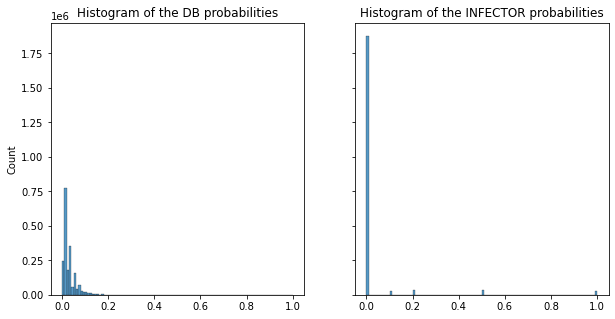

In [16]:
w = np.ones(N_TARGETS, dtype=np.float32)
train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)

X_train, Yemb_train, X_test, Yemb_test, Y_train, Y_test = create_train_test(train_id)
# X_train, Y_train, X_test, Y_test, Yemb_train, Yemb_test = create_train_test(train_id)
dataset = torch.utils.data.TensorDataset(X_train, Y_train) 

fig, ax = plt.subplots(1,2, figsize = (10,5), sharey=True)
sns.histplot(Y_train.flatten(), ax = ax[0], bins=100)
ax[0].set_title("Histogram of the DB probabilities")
sns.histplot(Yemb_train.flatten(), ax = ax[1], bins=100)
ax[1].set_title("Histogram of the INFECTOR probabilities")
plt.show()

Print training

In [8]:
def print_training(loss, train, test, train_dni, test_dni, title = "") : 

    fig, ax = plt.subplots(1,3, figsize = (15,5))
    plt.suptitle(title)
    ax[0].plot(loss)
    ax[0].set_title('Learning curve')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')

    ax[1].plot(train, label="train_scores")
    ax[1].plot(test, label="test_scores")
    ax[1].set_title('Quality')
    ax[1].set_ylabel('expected #influenced')
    ax[1].set_xlabel('epoch')
    ax[1].legend()

    ax[2].plot(train_dni, label="train_scores")
    ax[2].plot(test_dni, label="test_scores")
    ax[2].set_title('data-based quality')
    ax[2].set_ylabel('different nodes influenced')
    ax[2].set_xlabel('epoch')
    ax[2].legend()
    plt.show()


Evaluation function

In [9]:
def dni(seeds, Y) : 
    """
    estimates the number of Different Nodes Infected given a seed set and a DATA-BASED label. 
        If a data-based label of (u,v) is positive, it means that v appears in at least one cascade of u
    for each column(target) if one of the labels is >0 then it appears in a cascade provoqued by one of the seeds
    """
    return (Y[seeds,:].sum(dim=0) > 0).sum().item() 

def eval_dni(net, X, Y):
    """
    input : X[instances, nI, nT, nF], Y[instances, nI, nT]
    estimates number of different nodes infected based on the cascades
    """
    X = X.to(device)
    Y = Y.to(device)
    result = np.mean([  dni(    greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1]    ,Y[i]) for i in range(X.shape[0])])
    return float(result) #float is here to delete the gradient if there is a torch gradient

def eval_grd(net, X, Y):
    """
    estimates expectation of dni in the bipartite graph: sum(1-prod(1-p_uv))
    """
    X = X.to(device)
    Y = Y.to(device)
    # print(np.mean([greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1].__len__() for i in range(X.shape[0])]))
    result = np.mean([    set_func(   greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1], Y[i, :, :], w) for i in range(X.shape[0])])
    return float(result)

def eval_loss(net, X, Y, loss):
    """
    validation loss
    """
    X = X.to(device)
    Y = Y.to(device)
    result = np.mean([np.sum( ( net(X[i,:,:,:]).view_as(Y[0]) - Y[i, :, :] ).cpu().detach().numpy() **2. ) for i in range(X.shape[0])])
    return float(result)

def eval_rnd(X, Y):
    """
    Randomly selects seeds and computes influence
    """
    X = X.to(device)
    Y = Y.to(device)
    sol = random.sample(range(N_INFLUENCERS),k)   
    return np.mean([set_func(sol, Y[i,:,:], w) for i in range(X.shape[0])])

Random

In [10]:
rd_score_xtrain = np.mean([eval_rnd(X_train, Y_train) for _ in range(10)])
rd_score_xtest = np.mean([eval_rnd(X_test, Y_test) for _ in range(10)])
print(f"Average random score X_train : {rd_score_xtrain}")
print(f"Average random score X_test : {rd_score_xtest}")

wandb.log({"rd_score_xtrain" : rd_score_xtrain})
wandb.log({"rd_score_xtest" : rd_score_xtest})

Average random score X_train : 192.57756366729737
Average random score X_test : 188.93883819580077


Error: You must call wandb.init() before wandb.log()

### Decision focused

Model definition

In [182]:
train_scores_df = []
test_scores_df  = []
train_dni_df = []
test_dni_df  = []
loss_df = []
seeds_df = []

net_df = make_fc(N_FEATURES, num_layers, activation, hidden_sizes, dropout)
net_df.apply(init_weights)
net_df = net_df.to(device)
#net = net.half()
net_df.modules

<bound method Module.modules of Sequential(
  (0): Linear(in_features=22, out_features=150, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.15, inplace=False)
  (3): Linear(in_features=150, out_features=1, bias=True)
  (4): Hardtanh(min_val=0, max_val=1.0)
)>

Training

In [183]:

print("epoch | loss | train_score | test_score | train_dni | test_dni")

optimizer = torch.optim.Adam(net_df.parameters(), lr = learning_rate, betas = (momentum, 0.999))
marginal_vec_pred = partial(marginal_vec, w = w)

for epoch in range(30):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X = X.to(device)
            P = P.to(device)
            
            true_set_func = partial(set_func, P = P, w = w)
            pred = net_df(X).view_as(P)                
            fn = GreedyOptimizer.apply
            loss -= fn(pred, true_set_func, marginal_vec_pred, N_INFLUENCERS,  k,  eps, sample_size, beta)
            # del(X)
            del(P)
        
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_score = eval_grd(net_df, X_train, Y_train)
    test_score  = eval_grd(net_df, X_test, Y_test)
    
    train_dni = eval_dni(net_df, X_train, Yemb_train)
    test_dni  = eval_dni(net_df, X_test, Yemb_test)

    print(torch.mean(net_df(X)))

    loss_df.append(loss.item())

    wandb.log({ "epoch_df" : len(loss_df), 
                "loss_df" : loss.item(), 
                "train_score_df" : train_score, 
                "test_score_df" : test_score,
                "train_dni_df" : train_dni, 
                "test_dni_df" : test_dni},)
    
    print(f"{len(loss_df)} | {loss.item()} | {train_score} | {test_score} | {train_dni} | {test_dni}")

    train_scores_df.append(train_score)
    test_scores_df.append(test_score)
    train_dni_df.append(train_dni)
    test_dni_df.append(test_dni)


epoch | loss | train_score | test_score | train_dni | test_dni
tensor(0.0469, grad_fn=<MeanBackward0>)
1 | -220.3639678955078 | 206.03979873657227 | 197.99533081054688 | 367.375 | 374.0
tensor(0.0474, grad_fn=<MeanBackward0>)
2 | -228.24526977539062 | 213.30115509033203 | 206.59239959716797 | 323.375 | 334.5
tensor(0.0315, grad_fn=<MeanBackward0>)
3 | -240.5443115234375 | 224.85342025756836 | 217.57981872558594 | 181.75 | 173.0
tensor(0.0191, grad_fn=<MeanBackward0>)
4 | -241.22900390625 | 225.73712158203125 | 217.963623046875 | 180.875 | 177.5
tensor(0.0181, grad_fn=<MeanBackward0>)
5 | -241.96707153320312 | 225.8770294189453 | 218.1991424560547 | 176.75 | 172.5
tensor(0.0134, grad_fn=<MeanBackward0>)
6 | -241.8548583984375 | 225.82129287719727 | 217.43753814697266 | 180.375 | 183.0
tensor(0.0103, grad_fn=<MeanBackward0>)
7 | -241.95298767089844 | 225.87458992004395 | 217.6895980834961 | 186.75 | 178.0
tensor(0.0073, grad_fn=<MeanBackward0>)
8 | -242.69400024414062 | 226.5192794799804

Plot Curve

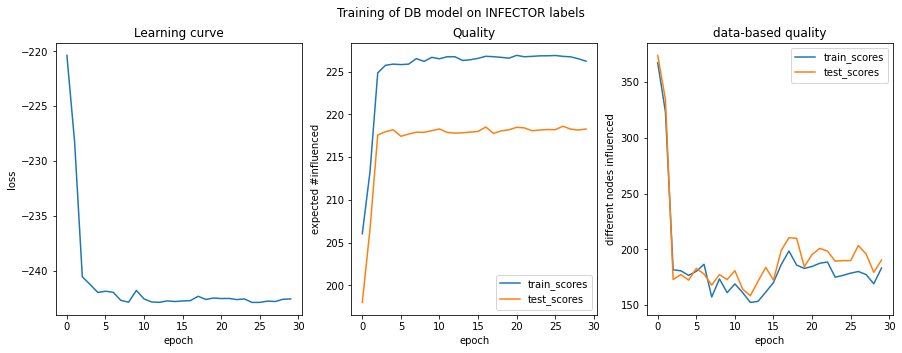

In [184]:
print_training(loss_df, train_scores_df, test_scores_df,train_dni_df, test_dni_df, "Training of DB model on INFECTOR labels")

### 2 Stage

Model definiton

In [13]:

train_scores_2s = []
test_scores_2s  = []
train_dni_2s = []
test_dni_2s  = []
loss_2s = []
val_loss_2s = []

net_2s = make_fc(N_FEATURES, num_layers, activation, hidden_sizes, dropout=dropout)
net_2s.apply(init_weights)
net_2s = net_2s.to(device)
print(net_2s.modules)

loss_fn = nn.MSELoss()
def loss_unbalanced(pred, P) : 
    """
    to counter the sparsity of the data, when the model predicts lower probabilities than the ground truth, the loss is higher
    """
    # neg = pred < P
    # pos = pred > P
    # return 100 * loss_fn(pred[neg], P[neg]) + loss_fn(pred[pos],P[pos])
    phi = 0.5
    return torch.sum(torch.exp(phi * (P - pred)) - phi * (P-pred) - 1)

optimizer = torch.optim.Adam(net_2s.parameters(), lr = learning_rate)
# optimizer = torch.optim.SGD(net_2s.parameters(), lr = 0.1)

<bound method Module.modules of Sequential(
  (0): Linear(in_features=22, out_features=150, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.15, inplace=False)
  (3): Linear(in_features=150, out_features=1, bias=True)
  (4): Hardtanh(min_val=0, max_val=1.0)
)>


Training

In [197]:

print("epoch | loss | val loss | train_score | test_score | train_dni | test_dni")

for epoch in range(30):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, ) #shuffle=True 
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X, P = X.to(device), P.to(device)
            pred = net_2s(X).view_as(P)
            loss += loss_fn(pred, P)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(net_2s.parameters(), 1.)
        optimizer.step()
    
    print(torch.mean(net_df(X)))

    val_loss = eval_loss(net_2s, X_test, Y_test, loss_fn)
    train_score = eval_grd(net_2s, X_train, Y_train)
    test_score  = eval_grd(net_2s, X_test, Y_test)
    train_dni = eval_dni(net_2s, X_train, Yemb_train)
    test_dni  = eval_dni(net_2s, X_test, Yemb_test)
    print(f"{len(loss_2s)} | {loss} | {val_loss} | {train_score} | {test_score} | {train_dni} | {test_dni}" )   

    train_scores_2s.append(train_score)
    test_scores_2s.append(test_score)     
    train_dni_2s.append(train_dni)
    test_dni_2s.append(test_dni)     
    val_loss_2s.append(val_loss)
    loss_2s.append(loss.item())

    wandb.log({ "epoch_2s" : len(loss_2s), 
                "loss_2s" : loss.item(), 
                "val_loss_2s" : val_loss,
                "train_score_2s" : train_score, 
                "test_score_2s" : test_score,
                "train_dni_2s" : train_dni, 
                "test_dni_2s" : test_dni})

epoch | loss | val loss | train_score | test_score | train_dni | test_dni
tensor(0.0266, grad_fn=<MeanBackward0>)
90 | 0.0011632709065452218 | 257.1028747558594 | 218.8228988647461 | 207.15079498291016 | 264.5 | 245.0
tensor(0.0266, grad_fn=<MeanBackward0>)
91 | 0.0011627019848674536 | 257.0709228515625 | 217.83138465881348 | 209.12611389160156 | 259.5 | 248.0
tensor(0.0266, grad_fn=<MeanBackward0>)
92 | 0.0011631938396021724 | 257.04815673828125 | 218.79646492004395 | 209.66543579101562 | 261.375 | 232.5
tensor(0.0266, grad_fn=<MeanBackward0>)
93 | 0.0011624022154137492 | 257.1277770996094 | 218.53168869018555 | 209.47698974609375 | 257.125 | 255.0
tensor(0.0266, grad_fn=<MeanBackward0>)
94 | 0.0011633632238954306 | 257.03399658203125 | 219.77054023742676 | 209.1352081298828 | 262.25 | 247.5
tensor(0.0266, grad_fn=<MeanBackward0>)
95 | 0.0011632229434326291 | 256.96343994140625 | 219.3348274230957 | 209.708984375 | 254.0 | 259.5
tensor(0.0266, grad_fn=<MeanBackward0>)
96 | 0.001162983

Plot Curve

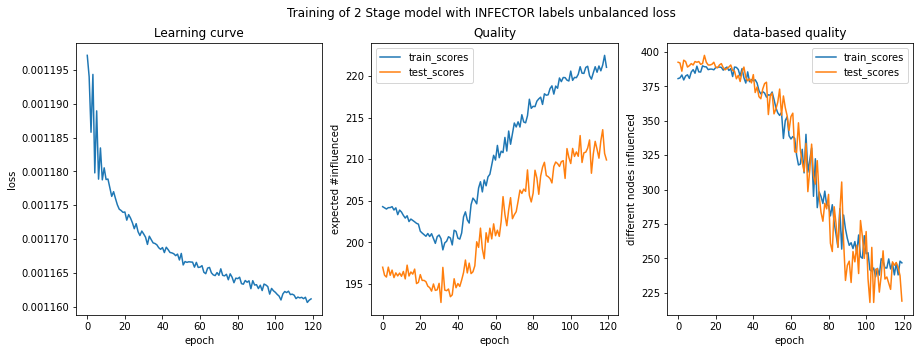

In [198]:
print_training(loss_2s, train_scores_2s, test_scores_2s, train_dni_2s, test_dni_2s,"Training of 2 Stage model with INFECTOR labels unbalanced loss")


### Hyperparameter tuning

Sweep df

In [225]:
sweep_config = {
  "program" : "grd_main",
  "name" : "sweep df - various hp - db labels",
  "early_terminate":{
    "type": "hyperband",
    "min_iter": 3},
  "method" : "bayes",
  "metric":{
    "name": "test_dni_df",
    "goal": "maximize",},

  "parameters" : {
    #Varying parameters
    "eps" : {"distribution" : "log_uniform_values", "min" : 0.01, "max" : 0.2},
    "learning_rate" : {"distribution" : "log_uniform_values", "min" : 1e-4, "max" : 1e-2},
    "momentum" : {"distribution" : "log_uniform_values", "min" : 0.8, "max" : 1.},
    "dropout" : {"distribution" : "log_uniform_values", "min" : 0.01, "max" : 1.},
    "layer_size" : {"min" : 50, "max" : 250},
    "sample_size" : {"min" : 1, "max" : 50},

    #instances parameters
    "N_INFLUENCERS": {"value" : N_INFLUENCERS},
    "N_TARGETS": {"value" : N_TARGETS},
    "N_FEATURES":{"value" : N_FEATURES},
    "N_INSTANCES":{"value" : N_INSTANCES},
    "instance_path" : {"value" : instance_path},
    "labels" : {"value" : "data-based}"},

    #labels parameters

    #greedy parameters
    "beta" :{ "value" : beta},                 
    "k" : {"value" : k},             

    #ML parameters
    "epochs": {"value" : 60},
    "batch_size": {"value" : batch_size},
    "num_layers" : {"value" : num_layers},
    "activation" : {"value" : activation},
    
  }
}
    
def train_df():
  with wandb.init() as run:
    config = wandb.config
    loss_df = []
    net_df = make_fc(config["N_FEATURES"], config["num_layers"], config["activation"], [config["layer_size"]], dropout=config["dropout"])
    net_df.apply(init_weights)
    net_df = net_df.to(device)
      
    optimizer = torch.optim.Adam(net_df.parameters(), lr = config["learning_rate"], betas = (config["momentum"], 0.999))
    marginal_vec_pred = partial(marginal_vec, w = w)

    for _ in range(60):
        
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = config["batch_size"])
        for X_batch, P_batch in data_loader:
            loss = 0 
            for X, P in zip(X_batch, P_batch):
                X = X.to(device)
                P = P.to(device)
                
                true_set_func = partial(set_func, P = P, w = w)
                pred = net_df(X).view_as(P)                
                fn = GreedyOptimizer.apply
                loss -= fn(pred, true_set_func, marginal_vec_pred, config["N_INFLUENCERS"],  config["k"],  config["eps"], config["sample_size"], config["beta"])
                del(X)
                del(P)
            
            loss = loss / batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_score = eval_grd(net_df, X_train, Y_train)
        test_score  = eval_grd(net_df, X_test, Y_test)
        
        train_dni = eval_dni(net_df, X_train, Y_train)
        test_dni  = eval_dni(net_df, X_test, Y_test)

        loss_df.append(loss.item())

        wandb.log({ "epoch_df" : len(loss_df), 
                    "loss_df" : loss.item(), 
                    "train_score_df" : train_score, 
                    "test_score_df" : test_score,
                    "train_dni_df" : train_dni, 
                    "test_dni_df" : test_dni},)


In [226]:
count = 40 # number of runs to execute
sweep_df = wandb.sweep(sweep_config)
wandb.agent(sweep_df, function=train_df, count=count, project='influence-maximization')

Create sweep with ID: 18n9qte2
Sweep URL: https://wandb.ai/mario-michelessa/influence-maximization/sweeps/18n9qte2


wandb: Agent Starting Run: gue4jy2q with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.011621952786836176
wandb: 	epochs: 60
wandb: 	eps: 0.05081357834789647
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 50
wandb: 	learning_rate: 0.003889023549846177
wandb: 	momentum: 0.8656821205240943
wandb: 	num_layers: 2
wandb: 	sample_size: 36


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,▇▇▂█▂▃▂▂▂▂▂▂▁▂▂▃▃▂▄▅▂▁▂▂▁▂▂▂▁▁▂▂▄▂▂▂▁▁▁▁
test_dni_df,▂▁▇▇██▄▄▄▄▄▄▄▄▄▂▄▄▄▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
test_score_df,▁▄▂▅▅█▆▆▆▇▇▇▇▇▇▅▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇
train_dni_df,▁▂▇▄█▆▄▄▃▅▅▅▅▅▄▃▅▄▅▄▃▃▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄
train_score_df,▁▄▄▄▅▆▇▇▇▇▇▇▇█▇▅▇▇▇▆█▇▇▇████▇███▇██▇▇███
epoch_df,60
loss_df,-333.3602
test_dni_df,405.0
test_score_df,318.97963
train_dni_df,408.375


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u4ocpy21 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.05756304253976032
wandb: 	epochs: 60
wandb: 	eps: 0.013007124258882667
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 155
wandb: 	learning_rate: 0.0018623811179994032
wandb: 	momentum: 0.9656397424456786
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,▄█▅▇▄▃▂▃▂▁▁▁▁▁▁▁▂▂▂▂▂▂▄▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁
test_dni_df,▆▅▄▁▆▇▆▆▆▅▆▇▇▇▅▆▄▅██████▇███▇▇▇▇▇▇▇▇▇▇▇▇
test_score_df,▄▂▄▁▅▆▇▅▇█████▇▇▆▆▇▆▇▆▆▆▇▇▆▆▇███████████
train_dni_df,▂▁▂▁▅▅▄▃▄▅▇▇▆▇▅▅▅▅████▇▇▇▇▇▇▇▆▆▇▇▇▇▇▆▇▇▇
train_score_df,▄▁▅▃▆▆▄▃▆▇▇▇▇▇▇▇▆▇▇▇▆▆▆▇▇▇▇▇▇▇██████████
epoch_df,60
loss_df,-330.91574
test_dni_df,405.0
test_score_df,319.41742
train_dni_df,407.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: umm803ws with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.8218850318351687
wandb: 	epochs: 60
wandb: 	eps: 0.05277181769003392
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 238
wandb: 	learning_rate: 0.00010272342298331736
wandb: 	momentum: 0.9134407875038736
wandb: 	num_layers: 2
wandb: 	sample_size: 50


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▇▅▅▅▅▄▅▃▄▅▅▅▅▄▄▄▅▄▃▂▃▁▂▄▂▂▂▁▂▂▂▁▂▁▂▁▂▁▁
test_dni_df,▃▁▅▅▆▄▆▅▅▇▅▅▆▅▅▇▅▅▆▆▆▆▇█▇▆█▅▆▇▇▆▇█▆▇▇▇▇▆
test_score_df,▁▃▄▆▄▅▄▅▃▅▄▄▅▅▅▆▄▆▆▅▇▆▆▇▇▅▆▇▆▆▇▇▇▇▇█▆▇▇▇
train_dni_df,▁▃▄▃▅▄▄▅▄▅▆▆▅▆▆▅▇▇▇▆▇█▇█▇█▇▇█▇▇▇▇█▇▇█▇▇█
train_score_df,▁▂▄▃▄▄▅▄▆▅▅▆▆▆▆▅▆▆▆▇▇▇▇▇▇█▇▇▇▇███▇██████
epoch_df,60
loss_df,-327.80536
test_dni_df,406.0
test_score_df,318.687
train_dni_df,413.0


wandb: Agent Starting Run: q6lacdaj with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.6472486817661195
wandb: 	epochs: 60
wandb: 	eps: 0.04208779832665831
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 206
wandb: 	learning_rate: 0.0003249335276123262
wandb: 	momentum: 0.939299149581925
wandb: 	num_layers: 2
wandb: 	sample_size: 46


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▇▆▆▃▂▁▂▁▁▁▁▂▂▂▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁
test_dni_df,▁▂▅▅▅▅▅█▆▇▇▇▆▆▅▅▅██▇▇▆▅▅▆▇▇▇▆█▆▆▅▅▅▅▇▇▇▆
test_score_df,▁▁▂▂▃▁▄▆█▅▆▇▇▆▆▆▆█▇█▇▆▆▆▇▆▆▆▆▇▆▆▇██▇██▆▇
train_dni_df,▁▁▄▅▄▅▇█▇▆█▇▇▇▇▇▇██▇█▇▇█▇▆███▇▇▇▇▇█▇▇▇▇▇
train_score_df,▁▃▁▂▂▄▆▆▇▆▇▇▇▇▇▇█▇▇▇▇▇▇▇██▇█▇██▇▇████▇██
epoch_df,60
loss_df,-330.54245
test_dni_df,404.5
test_score_df,319.59698
train_dni_df,410.125


wandb: Agent Starting Run: d10du6j0 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.745766613361213
wandb: 	epochs: 60
wandb: 	eps: 0.03700773357901898
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 140
wandb: 	learning_rate: 0.0022907973999838683
wandb: 	momentum: 0.9865508939685697
wandb: 	num_layers: 2
wandb: 	sample_size: 31


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▄▄▃▂▄▂▄▂▃▂▁▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▂▁▂▂▂▁▂▂
test_dni_df,▁▄▂▆▅▆▄█▇▆▄▄▄▄▃▅▄▅▅▅▅▅▅▄▅▅▅▅▄▆▆▆▆▇▄▅▅▄▄▄
test_score_df,▁▂▂▃▃▄▄▄▄▅▆▅▆▅▅▆▅▅▆▆▇▆▅▆▆▆▅█▆▆▆▆▆▆▆▆▆▆▆▆
train_dni_df,▁▁▃▄▆▅▇▆▇▇▆▇▇▆▇▇▆▆▇▇▇▇▇█▇█▇▇██▇▇▇▇██▇▇▇▇
train_score_df,▁▂▃▃▅▅▅▅▆▇▇▇▇█▇▇▇▇▇█▇██████▇▇▇▇████▇█▇▇▇
epoch_df,60
loss_df,-325.97873
test_dni_df,404.0
test_score_df,318.5511
train_dni_df,407.0


wandb: Agent Starting Run: nhlr3v1p with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.01983306258220186
wandb: 	epochs: 60
wandb: 	eps: 0.05327584037044259
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 213
wandb: 	learning_rate: 0.0002205598707202147
wandb: 	momentum: 0.8113681882960787
wandb: 	num_layers: 2
wandb: 	sample_size: 31


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▇▆▆▃▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_df,▁▅▃▄▆▅▅▅▅▅▇▇▇▇▅▅▅▇█▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇█▇▇
test_score_df,▂▂▂▁▆▆▆▇▇▆█▇▇█▇▇██▇▇█▇██▇▇█▇███▇████▇█▇▇
train_dni_df,▁▁▄▄▇▇▆▇▇▇█▇▇█▇█▇▇██████▇██▇████████████
train_score_df,▁▁▂▃▇▇█▇▇██▇█▇█▇█████▇██████████████████
epoch_df,60
loss_df,-330.35168
test_dni_df,408.5
test_score_df,321.65628
train_dni_df,411.75


wandb: Agent Starting Run: 81alm6fz with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.023912175343735124
wandb: 	epochs: 60
wandb: 	eps: 0.09083947675374708
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 221
wandb: 	learning_rate: 0.0001897699983422893
wandb: 	momentum: 0.8113729769572101
wandb: 	num_layers: 2
wandb: 	sample_size: 27


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▆▅▂▁▂▃▁▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_df,▁▃▄▄█▆▆▄▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
test_score_df,▁▂▂▂▆█▇▆██▇▇█▇███████▇▇▇▇▇███▇▇███▇███▇▇
train_dni_df,▁▂▅▅▇▇▇▇████▇██▇███████▇█▇▇██▇██████████
train_score_df,▁▁▂▄▅▇▆▆▇▇██▇█▇████▇████▇▇▇█████████████
epoch_df,60
loss_df,-329.78363
test_dni_df,408.5
test_score_df,322.51337
train_dni_df,412.5


wandb: Agent Starting Run: 6pj1ejep with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.020289580724589657
wandb: 	epochs: 60
wandb: 	eps: 0.0514767240598486
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 234
wandb: 	learning_rate: 0.000391719302827414
wandb: 	momentum: 0.8049610837955943
wandb: 	num_layers: 2
wandb: 	sample_size: 17


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▅▅▅▂▁▁▁▅▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_df,▁▆▄▄▇▇▆▆▇▇▆▆▇▇▇█▇█▇▇▆▇█▇██▇▇▇▇▇▇▇▇▇█▇▇▇▇
test_score_df,▁▃▃▃▃▇▇▇▇▄▇████▇▇███▇▇▆▇█████▇▇▇██████▇▇
train_dni_df,▁▄▄▅▅▆▇▇█▅▇███▇███▇▇▇▇█▇████████████████
train_score_df,▁▄▄▄▄▇██▇▅▇███████████▆▇▇▇██████████████
epoch_df,60
loss_df,-329.94818
test_dni_df,408.5
test_score_df,321.31238
train_dni_df,411.75


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dwwtptvp with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.01124148494678705
wandb: 	epochs: 60
wandb: 	eps: 0.033134045394735176
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 239
wandb: 	learning_rate: 0.00015261829330379025
wandb: 	momentum: 0.8210379146460729
wandb: 	num_layers: 2
wandb: 	sample_size: 30


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▅▅▅▅▅▅▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
test_dni_df,▁▄▄▆▆▆▆▇████▇▇█▆▆▆▇▇▇▇▇▇▆▇▇█▇▇▇▇▇██▇▇▇▇▇
test_score_df,▁▃▄▄▄▄▄▅▇▇██▇▇▇▇███████████████▇▇████▇▇█
train_dni_df,▁▂▄▅▄▅▆▆█████▇▇▇██████▇███▇█████▇████▇▇█
train_score_df,▁▃▄▄▄▄▄▅▇▇▇▇▇█▇▇█████████████████▇████▇█
epoch_df,60
loss_df,-330.39383
test_dni_df,408.5
test_score_df,322.77724
train_dni_df,412.5


wandb: Agent Starting Run: kk3y0eww with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.06526782133812246
wandb: 	epochs: 60
wandb: 	eps: 0.021832104404131115
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 247
wandb: 	learning_rate: 0.0001606975156583262
wandb: 	momentum: 0.8099524622742961
wandb: 	num_layers: 2
wandb: 	sample_size: 12


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▆▆▆▆▆▆▆▆▇▆▂▂▂▂▂▂▂▁▁▁▂▂▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
test_dni_df,▁▂▂▂▂▂▂▂▂▄▇▇███▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▆▆▇▇▅▅▇▇▇
test_score_df,▁▂▂▂▂▂▁▁▃▃▁▄▇▆▇▇▇▆▇██▇████▇▇██▇▆▅▆▅▆▇▆▆▇
train_dni_df,▁▂▃▃▄▄▄▄▅▄▅▇█▇████████▇▇▇▇▇█▇█▇█▆▇▆▇▇▇▇▇
train_score_df,▁▃▂▃▃▃▃▄▄▄▃▆▇▇▇▇▇▇▇█████▇███████▇▇██████
epoch_df,60
loss_df,-330.67773
test_dni_df,408.5
test_score_df,321.22012
train_dni_df,410.625


wandb: Agent Starting Run: ypf59f8d with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.013534501049720747
wandb: 	epochs: 60
wandb: 	eps: 0.06693111548804453
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 245
wandb: 	learning_rate: 0.0001408882980108134
wandb: 	momentum: 0.8003669992241043
wandb: 	num_layers: 2
wandb: 	sample_size: 23


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▅▆▅▅▅▅▅▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_df,▁▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇
test_score_df,▁▄▄▃▄▄▄▄▆██▇██▇██████▇███████████████▇██
train_dni_df,▁▃▅▅▅▄▅▆▇█████████▇▇▇▇██████████████████
train_score_df,▁▃▄▄▄▄▅▅▆▇▇██▇▇█████▇▇▇███████▇█▇███████
epoch_df,60
loss_df,-330.21817
test_dni_df,408.5
test_score_df,323.32465
train_dni_df,411.75


wandb: Agent Starting Run: by6d9vdj with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.025398335105855645
wandb: 	epochs: 60
wandb: 	eps: 0.09908304269524464
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 243
wandb: 	learning_rate: 0.00019547347798657343
wandb: 	momentum: 0.8037947797865577
wandb: 	num_layers: 2
wandb: 	sample_size: 40


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▆▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_df,▁▅▅▅████████▇▇█▇██████▆▇████████████████
test_score_df,▁▂▁▁███▇█▇█▇▇▇▇▇█████▇▇█▇▇██▇▇▇█▇▇▇▇███▇
train_dni_df,▁▃▄▅▇██▇▇██▇██▇▇█▇▇▇██▇▇▇████████▇██████
train_score_df,▂▁▃▄▆▇▇▇█████▇███▇████▇▇▇▇██████████████
epoch_df,60
loss_df,-330.16806
test_dni_df,408.5
test_score_df,322.51337
train_dni_df,412.25


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6tm6umib with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.034878164652187696
wandb: 	epochs: 60
wandb: 	eps: 0.060316486123371205
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 243
wandb: 	learning_rate: 0.00013224116050794782
wandb: 	momentum: 0.8197067645104205
wandb: 	num_layers: 2
wandb: 	sample_size: 25


epoch_df,▁▂▃▅▆▇█
loss_df,█▄▃▂▁▁▁
test_dni_df,▁▄▄▄▄██
test_score_df,▁▄▄▅▅██
train_dni_df,▁▂▄▄▅▇█
train_score_df,▁▂▄▅▅▆█
epoch_df,7
loss_df,-309.73123
test_dni_df,403.0
test_score_df,309.29062
train_dni_df,401.75


wandb: Agent Starting Run: wsr72806 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.07487068114944413
wandb: 	epochs: 60
wandb: 	eps: 0.01605644607665011
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 232
wandb: 	learning_rate: 0.0002088224882549668
wandb: 	momentum: 0.8125587722179245
wandb: 	num_layers: 2
wandb: 	sample_size: 13


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,▆▆▅▅▆█▅▄▃▂▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_df,▁▁▁▂▅▅▅▅▇█▇▆▇▆▅▇▆▇▅▇▆▅▅▇▇▆█▇▆▇▅▅▇█▅▇▇▇▇█
test_score_df,▂▂▃▂▂▁▂▃▄▆▇▆▇▇▇█▆▇▇▇▆▇█▇▇█▇▇▇▇▇▇█▇▆▇█▇▇█
train_dni_df,▁▂▃▅▄▃▅▆▇████▇▇█▇█▇▇▇▇▇▇▇▇██▇▇▇▇▇███▇██▇
train_score_df,▃▃▄▄▃▁▅▅▅▇▇▇██▇█▇███▇▇██████▇█████▇█████
epoch_df,60
loss_df,-330.03903
test_dni_df,411.0
test_score_df,324.16428
train_dni_df,411.5


wandb: Agent Starting Run: m0vc83zs with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.02956042219182416
wandb: 	epochs: 60
wandb: 	eps: 0.07906948698647276
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 202
wandb: 	learning_rate: 0.0004385354381386401
wandb: 	momentum: 0.8038007454887588
wandb: 	num_layers: 2
wandb: 	sample_size: 24


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▇▄▄▂▂▂▂▂▂▂▁▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_df,▁▁▇▇▇█▇▇▅▄▅▅▅▂▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
test_score_df,▁▁▆▅▅▆▆▆▄▄▅▄▄▃▅▅▅▅▄▅▅▅▅▄▄▄▅▄▄█▅▄▄▅▅▅▅▅▅▅
train_dni_df,▁▁█▇███▆▇▆▆▆▆▅▆▇▆▆▇▆▆▆▆▆▆▆▆▆▇▆▆▆▆▆▇▇▆▆▆▆
train_score_df,▁▂▆▆▆▇▇▇▇▇▇▇▇▆▇▇█▇██████████████████████
epoch_df,60
loss_df,-330.79919
test_dni_df,405.5
test_score_df,318.66026
train_dni_df,409.0


wandb: Agent Starting Run: j7f0uorl with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.468400194486282
wandb: 	epochs: 60
wandb: 	eps: 0.07697891092837739
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 80
wandb: 	learning_rate: 0.005627788668499458
wandb: 	momentum: 0.9667616938447438
wandb: 	num_layers: 2
wandb: 	sample_size: 5


epoch_df,▁▂▂▃▄▅▅▆▇▇█
loss_df,▅▃▅█▇▄▃▃▃▂▁
test_dni_df,▅█▆▅▂▁▂▃▄▇▆
test_score_df,▆█▇▆▁▂▃▂▅▆█
train_dni_df,▁▆▇▃▅▄▅▆█▇▇
train_score_df,▂▅▆█▃▁▂▄▅▆█
epoch_df,11
loss_df,-305.00348
test_dni_df,394.0
test_score_df,307.37985
train_dni_df,396.75


wandb: Agent Starting Run: s1ffkdrq with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.047536703915065974
wandb: 	epochs: 60
wandb: 	eps: 0.1154319750862576
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 198
wandb: 	learning_rate: 0.0003802781696044844
wandb: 	momentum: 0.9098558869097024
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_df,▁▂▃▃▄▅▆▆▇█
loss_df,██▆▄▃▃▁▁▁▁
test_dni_df,▁▁▂▅▇▇▇▅▆█
test_score_df,▁▁▂▃▅▇▇▆▇█
train_dni_df,▁▃▄▅███▇▆▇
train_score_df,▁▁▃▄▇▇█▇▇▇
epoch_df,10
loss_df,-315.4668
test_dni_df,403.0
test_score_df,318.01927
train_dni_df,404.0


wandb: Agent Starting Run: rfzpoxtn with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.010069774330842962
wandb: 	epochs: 60
wandb: 	eps: 0.02469952039891115
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 237
wandb: 	learning_rate: 0.00014715587123213003
wandb: 	momentum: 0.8257242990696532
wandb: 	num_layers: 2
wandb: 	sample_size: 27


epoch_df,▁▂▃▃▄▅▆▆▇█
loss_df,█▂▂▁▃▂▃▅▂▁
test_dni_df,▂▂▁███▇▅██
test_score_df,▃▄▄▆▄▄▅▁▅█
train_dni_df,▁▃▄▆▅▆▆▆▇█
train_score_df,▁▂▃▄▅▅▅▄▇█
epoch_df,10
loss_df,-310.039
test_dni_df,403.5
test_score_df,312.51114
train_dni_df,408.125


wandb: Agent Starting Run: t0xj6znf with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.4731432645028982
wandb: 	epochs: 60
wandb: 	eps: 0.14479436786863897
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 119
wandb: 	learning_rate: 0.006306613400841031
wandb: 	momentum: 0.9005542849415996
wandb: 	num_layers: 2
wandb: 	sample_size: 7


epoch_df,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss_df,▇██▄▄▃▃▃▃▄▃▃▃▄▁▃▃▂▂▂▄▄▃▃▂▃▃▂▂
test_dni_df,▁▂▅▆█▆▆▅▄▄▃▇▇▇▇▆▇▄▆▆▄▇▅▅▆▅▄▄▆
test_score_df,▂▅▄▅▅▆▆▆▆▅▄▆██▇▅▆▅▅▇▁▇█▇▆▅▃▆▇
train_dni_df,▁▅▅▄▆▇▇▆▇▅▆███▇▆▆█▆█▆▆▇▇█▇▇█▇
train_score_df,▁▅▅▃▆▇▆▇▇▇▆▇███▆▇▇▆▅▄▄▇▆▇▆█▆▆
epoch_df,29
loss_df,-317.03156
test_dni_df,398.0
test_score_df,310.36424
train_dni_df,397.5


wandb: Agent Starting Run: 6hw3asbd with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.040822430753959096
wandb: 	epochs: 60
wandb: 	eps: 0.0557174579573018
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 84
wandb: 	learning_rate: 0.0002876714944661919
wandb: 	momentum: 0.8960456051513073
wandb: 	num_layers: 2
wandb: 	sample_size: 8


epoch_df,▁▂▂▃▃▄▅▅▆▆▇▇█
loss_df,█▅▄▄▄▄▄▄▃▃▁▁▁
test_dni_df,▁▅▅▅▅▄▅▅▅▆▆██
test_score_df,▁▆▇▆▅▅▆▆▆▆▇▇█
train_dni_df,▁▃▂▄▃▅▅▅▆▇▇▇█
train_score_df,▁▅▄▆▅▆▆▆▆▇▇▇█
epoch_df,13
loss_df,-308.93005
test_dni_df,402.5
test_score_df,309.22906
train_dni_df,403.125


wandb: Agent Starting Run: ppw9eajk with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15853715750428005
wandb: 	epochs: 60
wandb: 	eps: 0.19326366630611955
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 121
wandb: 	learning_rate: 0.0033278942619227453
wandb: 	momentum: 0.9649138386482689
wandb: 	num_layers: 2
wandb: 	sample_size: 40


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,██▆▄▆▆▂▃▂▂▂▃▂▃▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
test_dni_df,▅█▄▅▂▁▅▆▅▅▅▄▆▆▆▆▆▅▆▆▆▆▆▆▅▆▆▅▅▅▅▆▆▆▆▅▅▅▆▅
test_score_df,▃▁▄▃▄▃▆▆▇▆▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇██▇▆▆▆▆
train_dni_df,▂▇▃▅▂▁▅▅▇▇▇▄▇▅▇▇▇▇▇█▇▆▆▆▆▇▇▆▇█▇▆▇▆▇▇▇▇▇▅
train_score_df,▁▁▄▂▄▄▆▅▇▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇████
epoch_df,60
loss_df,-331.77866
test_dni_df,404.0
test_score_df,318.55367
train_dni_df,406.0


wandb: Agent Starting Run: zp20s0hw with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.13578576538942805
wandb: 	epochs: 60
wandb: 	eps: 0.10744166562469754
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 57
wandb: 	learning_rate: 0.002752061789810223
wandb: 	momentum: 0.8888907362186039
wandb: 	num_layers: 2
wandb: 	sample_size: 12


epoch_df,▁▂▃▃▄▅▆▆▇█
loss_df,▅▄▁▄█▄▃▆▄▄
test_dni_df,▁▁▁▁▁▁▁▁▁▁
test_score_df,▁▁▁▁▁▁▁▁▁▁
train_dni_df,▁▁▁▁▁▁▁▁▁▁
train_score_df,▁▁▁▁▁▁▁▁▁▁
epoch_df,10
loss_df,-191.07941
test_dni_df,131.0
test_score_df,27.85
train_dni_df,23.125


wandb: Agent Starting Run: niz5auhn with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.027818590327208143
wandb: 	epochs: 60
wandb: 	eps: 0.0377822295612321
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 197
wandb: 	learning_rate: 0.0002865740714218838
wandb: 	momentum: 0.8297324549699598
wandb: 	num_layers: 2
wandb: 	sample_size: 33


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▅▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_df,▁▂▅▆██▆▆▇▆▆▆▅▅▅▅▅▆▇▆▆▇▆▅▆▆▆▇▆▆▅▅▇▆▆▆▆▆▆▆
test_score_df,▁▂▂▃▆███▇▆█▇▇▇▇▇██▇████▇█▇██▇██▇██████▇▇
train_dni_df,▁▂▄▆█████▇███▇▆█▇███▇█▇▇████▇▇█▇████████
train_score_df,▁▂▃▄▆▆▇▇▇▇█▇▇▇▇▇█▇█████▇██▇█▇███▇█▇█████
epoch_df,60
loss_df,-330.58002
test_dni_df,408.5
test_score_df,321.65427
train_dni_df,412.375


wandb: Agent Starting Run: 1epggh8c with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.4522321834420413
wandb: 	epochs: 60
wandb: 	eps: 0.033252902606156994
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 67
wandb: 	learning_rate: 0.0005124972629944225
wandb: 	momentum: 0.9769021792663364
wandb: 	num_layers: 2
wandb: 	sample_size: 15


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,▅▄▃▁█▅▆▇▆▆▄▃▂▅▅▆▅▆▄▅▇▄▇▃▅▆▆▄▅▃▇▆▆▆▆▄▄█▇▆
test_dni_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dni_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_df,60
loss_df,-186.92758
test_dni_df,131.0
test_score_df,27.85
train_dni_df,23.125


wandb: Agent Starting Run: 91q45r5b with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.03060275286064597
wandb: 	epochs: 60
wandb: 	eps: 0.011421989716051354
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 65
wandb: 	learning_rate: 0.0003739362083247949
wandb: 	momentum: 0.8665961651151006
wandb: 	num_layers: 2
wandb: 	sample_size: 25


epoch_df,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_df,█▇▇▇███▆▇▇▇▇▇▆▆▅▂▂▂▁▁▂▁▁▂▂▁▁▁▁
test_dni_df,▁▃▆▇▅▃▃▆▆▂▂▂▁▁▁▅▇█▇▇▇▇▇▇▇▆█▇▇▇
test_score_df,▂▂▃▃▃▁▂▄▄▄▃▅▄▄▅▆▇▇▇▇▇█▇█▇▇▇█▇█
train_dni_df,▁▂▄▄▄▄▅▅▄▄▃▄▃▃▅▅▇▇▇▆▇▆▇▇▇▇██▇█
train_score_df,▁▂▃▄▄▃▄▄▄▃▄▄▄▅▆▆▇▇████████████
epoch_df,30
loss_df,-330.00308
test_dni_df,404.5
test_score_df,321.26434
train_dni_df,412.75


wandb: Agent Starting Run: xl0hv1wu with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.7411478274315103
wandb: 	epochs: 60
wandb: 	eps: 0.14319463368835922
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 198
wandb: 	learning_rate: 0.0001609011601503779
wandb: 	momentum: 0.8614727206461493
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_df,▁▂▃▃▄▅▆▆▇█
loss_df,█▅▄▃▃▂▃▂▂▁
test_dni_df,▁▃▃▄▇▅▅▇▅█
test_score_df,▃▁▃██▅▇▆█▅
train_dni_df,▁▂▆▅▅▇▅█▆▇
train_score_df,▁▁▄▅▇▆█▆▇█
epoch_df,10
loss_df,-312.21353
test_dni_df,404.5
test_score_df,301.88028
train_dni_df,394.875


wandb: Agent Starting Run: 78cyuzq0 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.07291651765877315
wandb: 	epochs: 60
wandb: 	eps: 0.02057040343039309
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 106
wandb: 	learning_rate: 0.00016210895743639996
wandb: 	momentum: 0.8172184820668736
wandb: 	num_layers: 2
wandb: 	sample_size: 27


epoch_df,▁▃▅▆█
loss_df,█▁▃▁▁
test_dni_df,▂▇▁▇█
test_score_df,▂▄▁██
train_dni_df,▁▆▇▂█
train_score_df,▁▅█▆▇
epoch_df,5
loss_df,-309.6109
test_dni_df,398.0
test_score_df,308.00279
train_dni_df,399.0


wandb: Agent Starting Run: mgistdsw with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.08852106471702871
wandb: 	epochs: 60
wandb: 	eps: 0.14189029331912947
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 237
wandb: 	learning_rate: 0.0017847031261802348
wandb: 	momentum: 0.9178292378786572
wandb: 	num_layers: 2
wandb: 	sample_size: 20


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▇▆▆▄▂▂▂▄▄▂▂▂▂▂▂▁▂▁▁▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁
test_dni_df,▃▂▂▃▃▄▅█▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃▃
test_score_df,▁▁▁▁▄▅▅█▁▂▅▄▅▅▅▅▅▄▅▄▅▅▄▅▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅
train_dni_df,▁▃▄▅▅▆▇█▃▄▆▅▆▆▅▅▅▆▆▆▅▅▅▆▅▆▅▄▅▅▆▅▅▅▅▅▅▄▅▆
train_score_df,▁▁▃▄▄▆▅▅▃▄▇█▇▇██▇██▇▇█▇███▇██▇███████▇▇█
epoch_df,60
loss_df,-332.24051
test_dni_df,405.0
test_score_df,318.73793
train_dni_df,408.25


wandb: Agent Starting Run: gh9ia325 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.0395044718270753
wandb: 	epochs: 60
wandb: 	eps: 0.06800262785115717
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 172
wandb: 	learning_rate: 0.0018370899602901728
wandb: 	momentum: 0.91673814419514
wandb: 	num_layers: 2
wandb: 	sample_size: 46


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▇▂▂▂▂▂▂▄▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▂▁▁▂▂▂▂▁
test_dni_df,▁▃█▅▅▅▅▅▆▅▆▅▅▅▅▅▅▆▅▅▆▅▅▅▆▅▆▆▆▅▅▅▆▆▆▅▆▆▅▆
test_score_df,▁█▅██▇▇▆▇▇█▇▇▇▇▇▇▇█▇▇▇██▇█▇▇██▇▆▇▇▇▇▇▆▇▇
train_dni_df,▁▆█▅▅▆▆▅▆▅▇▇▄▅▆▆▅▆▅▅▅▅▅▆▅▅▆▆▆▅▆▆▆▆▅▅▆▅▅▅
train_score_df,▁▆▆▇▇▇▇▆▆█▇▇▇█▇▇████▇███▇▇█▇███▇██▇█████
epoch_df,60
loss_df,-331.729
test_dni_df,405.5
test_score_df,319.49933
train_dni_df,408.25


wandb: Agent Starting Run: z6etnrpq with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.693374613459226
wandb: 	epochs: 60
wandb: 	eps: 0.07967719818205948
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 132
wandb: 	learning_rate: 0.00013446665075213615
wandb: 	momentum: 0.80022079752203
wandb: 	num_layers: 2
wandb: 	sample_size: 11


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▅▆▅▅▅▅▅▅▅▅▄▅▄▅▃▄▄▁▂▁▁▂▂▂▁▂▂▁▂▁▁▂▁▂▁▁▂▁
test_dni_df,▁▂▅▄▅▂▂▇▆▆▃▆▃▇▅▇▆█▆▇▇▆▆██▆▇▆▇▆█▆▆█▆▇▇▇▇▇
test_score_df,▁▁▄▂▄▄▃▅▄▄▄▃▄▄▇▆▅▇▆▆▆█▆▅▆▇▇▆█▇▇▇█▇██▆▇▇▇
train_dni_df,▁▄▃▃▄▄▄▄▅▆▆▄▅▆▆▇▇▆▇█▆▇▇▇▇▇▇▇█▇██▇▇▇██▇▇█
train_score_df,▁▂▃▂▃▃▃▅▄▄▅▄▅▆▇▆▅▆▇▇▇▇█▇▇█▇▇██▇███▇█████
epoch_df,60
loss_df,-327.55313
test_dni_df,408.5
test_score_df,318.54057
train_dni_df,411.875


wandb: Agent Starting Run: ylhpw8vq with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.04450376607057232
wandb: 	epochs: 60
wandb: 	eps: 0.180295088078798
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 133
wandb: 	learning_rate: 0.00011627317429850928
wandb: 	momentum: 0.8721595997009807
wandb: 	num_layers: 2
wandb: 	sample_size: 37


wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch_df,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss_df,▂█▆▅▅▄▄▅▁▅▅▆▆▄▅▄▂▄▄▄▃▄▄▅▄▇▂▆▆▅▆▅▆▇▄▄▅▁▇▅
test_dni_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dni_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_df,53
loss_df,-189.32719
test_dni_df,131.0
test_score_df,27.85
train_dni_df,23.125


wandb: Agent Starting Run: vkv5bkyh with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.08964640834720651
wandb: 	epochs: 60
wandb: 	eps: 0.02481090451718204
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 179
wandb: 	learning_rate: 0.00025622297551868207
wandb: 	momentum: 0.948972440295767
wandb: 	num_layers: 2
wandb: 	sample_size: 39


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▇▇▇▆▆▂▂▂▂▁▁▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_df,▁▂▃▅▅▅▇▇██▇▆▇▇▇▅▆▇▆▇▆▆▆▆▆▇▇▇▆▆▆▆▆▆▆▆▅▇▆▆
test_score_df,▂▂▁▁▂▂▅▆▇█▇▇▇▇▇▆▇▆▇██▇▇██▇▇▇▇▇▇██▇▇█▇██▇
train_dni_df,▁▁▁▄▅▅▇██▇█████▇█▇██▇▇▇▆█▇▇█▆▇▇█▇▇▇███▇▇
train_score_df,▁▁▂▂▃▅▆▆▆▇▇▇▇█▇▇▇▇▇▇▇█▇█████████████████
epoch_df,60
loss_df,-330.29123
test_dni_df,408.0
test_score_df,320.10146
train_dni_df,411.375


wandb: Agent Starting Run: fac7ax63 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.7625014330732771
wandb: 	epochs: 60
wandb: 	eps: 0.0874873710064903
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 135
wandb: 	learning_rate: 0.0004225182449668774
wandb: 	momentum: 0.8381188617457497
wandb: 	num_layers: 2
wandb: 	sample_size: 39


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▅▅▅▅▄▅▅▅▁▄▁▂▂▂▂▂▁▁▂▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▂▂▁▁▁
test_dni_df,▁▄▅▄▃▂▆▄▆▅▆█▇▇▇▇▇▇▇▇▇▆▇▇▇▆▅▆▇▇▇▇▇▆█▇▇▇▇▇
test_score_df,▁▃▄▃▂▃▄▅▄▃▄▆▇▆▇▆▇▆▅▇█▇▇▇▇▇▇█▇▇█▇█▆█▇█▇▆█
train_dni_df,▁▂▃▄▄▃▅▅▆▆▇▇▇█▇▇████▇█▇▇▇▇▇███▇█▇████▇█▇
train_score_df,▁▂▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇█▇▇▇▇███▇█████████████▇
epoch_df,60
loss_df,-329.6814
test_dni_df,408.5
test_score_df,322.66676
train_dni_df,408.75


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4voepoxb with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.13235779622737415
wandb: 	epochs: 60
wandb: 	eps: 0.02768123408416143
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 175
wandb: 	learning_rate: 0.00015258788409786475
wandb: 	momentum: 0.9644105516510004
wandb: 	num_layers: 2
wandb: 	sample_size: 12


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▇▅▆▆▆▆▆▅▅▅▆▅▅▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
test_dni_df,▁▃▄▆▅▅▆▆▆▆▇▇▇▇▇███▇█▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▆▆▆▆▆
test_score_df,▁▃▄▃▄▄▃▄▅▄▅▅▅▅▅▆▇▆▇▆▇█▇▇▇▆▇▇█▇▇██▇▇▇▇███
train_dni_df,▁▂▃▃▃▃▅▄▅▅▅▅▆▆▇██▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▆▇
train_score_df,▁▂▄▄▄▃▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇███████▇▇████▇
epoch_df,60
loss_df,-325.2048
test_dni_df,404.0
test_score_df,323.09723
train_dni_df,410.75


wandb: Agent Starting Run: 6hcxoap0 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.01665544572428325
wandb: 	epochs: 60
wandb: 	eps: 0.03420226318778542
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 182
wandb: 	learning_rate: 0.00015791110979632026
wandb: 	momentum: 0.9923324607065838
wandb: 	num_layers: 2
wandb: 	sample_size: 42


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▇▆▅▆▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_df,▁▄▄▄▄▆▇██████▇▇▇▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇
test_score_df,▁▃▄▄▄▄▆▅▇▇▇▇████▇▇▇▇▇▇▇▇▇▇███████▇▇█████
train_dni_df,▁▂▄▅▅▅▆███████▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇▇
train_score_df,▁▂▃▄▄▄▅▆▆▆▇▇▇▇███▇▇▇▇▇██████████████████
epoch_df,60
loss_df,-330.0914
test_dni_df,408.5
test_score_df,321.65427
train_dni_df,412.125


wandb: Agent Starting Run: 4jp6qrum with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.1699956028414823
wandb: 	epochs: 60
wandb: 	eps: 0.01833925138027028
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.001629436676230503
wandb: 	momentum: 0.9700567766698694
wandb: 	num_layers: 2
wandb: 	sample_size: 37


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,▆█▆▃▃▂▂▂▃▃▂▁▁▂▂▂▂▂▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂
test_dni_df,▄▂▁▃▄▄▅▅▆█▅▅▅▅▅▅▅▅▆▆▅▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅
test_score_df,▃▁▃▆▆▆█▇▆▆██▇▆▇▇▇▇▇▇▇██▇▇▇████▇▆██▇▇▇▇▇▇
train_dni_df,▁▁▁▃▅▅▇▆▇█▇▇▆▅▅▆▆▆▇▇▇▇▇▆▆▆▇▆▇▇▆▆▆▇▆▇▆▇▆▇
train_score_df,▁▁▂▆▆▆▇▇▆▆██▇▇▇▇▇▇▇▇███▇▇▇████▇▇██▇█████
epoch_df,60
loss_df,-329.05719
test_dni_df,410.5
test_score_df,321.43253
train_dni_df,412.625


wandb: Agent Starting Run: bpsskqb7 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.01109010975905118
wandb: 	epochs: 60
wandb: 	eps: 0.11238902255008294
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 121
wandb: 	learning_rate: 0.008169096212170516
wandb: 	momentum: 0.936811650275638
wandb: 	num_layers: 2
wandb: 	sample_size: 30


epoch_df,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss_df,▅█▂▄▃▄▄▁▆▅▁▃▃▄▅▃▄▆▅▅▃▄▄
test_dni_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dni_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_df,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_df,23
loss_df,-189.72334
test_dni_df,131.0
test_score_df,27.85
train_dni_df,23.125


wandb: Agent Starting Run: 75igvmr2 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.9554816119766606
wandb: 	epochs: 60
wandb: 	eps: 0.03408437139472217
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 190
wandb: 	learning_rate: 0.00014665115915077047
wandb: 	momentum: 0.8991785345315904
wandb: 	num_layers: 2
wandb: 	sample_size: 28


epoch_df,▁▃▆█
loss_df,██▁▃
test_dni_df,▁▂▄█
test_score_df,█▆▄▁
train_dni_df,▁▇▆█
train_score_df,█▁▅▇
epoch_df,4
loss_df,-284.64886
test_dni_df,396.0
test_score_df,281.03795
train_dni_df,385.75


wandb: Agent Starting Run: 8woaw9lh with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.11183903556797516
wandb: 	epochs: 60
wandb: 	eps: 0.09782331102857345
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 187
wandb: 	learning_rate: 0.002232676164806002
wandb: 	momentum: 0.8669400431137934
wandb: 	num_layers: 2
wandb: 	sample_size: 45


epoch_df,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss_df,▅▃▂▃▂▃▂▂▁▂▂█▂▃▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▂▁▁
test_dni_df,▄▇▆▁▆█▇█▇▇▆▇▆█▅▇▆▆▆▆▇▇▆▆▆▆▆▆▆█▆▅
test_score_df,▁▅█▄▇▆▅▆▆▆▆▅▆▅▇▇▆▆▆▇▆▆▆▆▇▆▆▆▇█▆▆
train_dni_df,▆▅▅▃██▅▆▇▆▅▁▂▇▃▃▄▄▅▄▅▅▅▄▄▄▄▄▆▄▄▄
train_score_df,▁▅▄▅▆▄▇▆▆▆▆▅▆▄▇▇▆████▇██▇██▇██▆▆
epoch_df,32
loss_df,-332.92023
test_dni_df,403.0
test_score_df,318.30377
train_dni_df,407.625


wandb: Agent Starting Run: qbk00okq with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.01487979094629927
wandb: 	epochs: 60
wandb: 	eps: 0.011498495026635504
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 77
wandb: 	learning_rate: 0.0011922394697627685
wandb: 	momentum: 0.8492964980923489
wandb: 	num_layers: 2
wandb: 	sample_size: 24


epoch_df,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_df,█▆▂▃▁▂▁▁▁▁▂▃▃▂▁▂▁▂▂▁▁▁▂▂▂▂▇▇▄▄▂▂▁▁▁▁▁▁▁▁
test_dni_df,▁▁▄▃▄▄▄▄▃▃▂▁▃▃▄▄▄▂▂▄▄▄▄██▂▄▄▁▂▅▃▃▃▃▃▃▃▃▃
test_score_df,▁▅▅▆▇▇▆▇▇▇▅▄▆▆▆▆▆▅▆▆▆▆▅██▄▂▂▄▅▆▇▆▆▆▇▆▆▆▆
train_dni_df,▁▃▇▆▇▇▇▇▆▇▅▄▆▆▆▆▆▄▄▆▆▆▆▇█▄▄▄▃▅▆▆▆▆▆▆▆▆▆▆
train_score_df,▂▅▆▆▇▇▇▇▇█▇▆▆▇█▇█▆▇▇▇▇▆▇▆▅▁▂▄▆▇▇████████
epoch_df,60
loss_df,-330.37231
test_dni_df,404.5
test_score_df,319.41742
train_dni_df,408.625


Sweep 2 stage

In [17]:
sweep_config = {
  "program" : "grd_main",
  "name" : "sweep 2s - various hp - infector labels",
  "early_terminate":{
    "type": "hyperband",
    "min_iter": 3},
  "method" : "bayes",
  "metric":{
    "name": "test_dni_2s",
    "goal": "maximize",},

  "parameters" : {
    #Varying parameters
    "phi" : {"distribution" : "log_uniform_values", "min" : 0.01, "max" : 0.2},
    "learning_rate" : {"distribution" : "log_uniform_values", "min" : 1e-4, "max" : 1e-2},
    "momentum" : {"distribution" : "log_uniform_values", "min" : 0.8, "max" : 1.},
    "dropout" : {"distribution" : "log_uniform_values", "min" : 0.01, "max" : 1.},
    "layer_size" : {"min" : 50, "max" : 300},
    "sample_size" : {"min" : 1, "max" : 50},

    #instances parameters
    "N_INFLUENCERS": {"value" : N_INFLUENCERS},
    "N_TARGETS": {"value" : N_TARGETS},
    "N_FEATURES":{"value" : N_FEATURES},
    "N_INSTANCES":{"value" : N_INSTANCES},
    "instance_path" : {"value" : instance_path},
    "labels" : {"value" : "infector}"},
     
    "k" : {"value" : k},             

    #ML parameters
    "epochs": {"value" : 30},
    "batch_size": {"value" : batch_size},
    "num_layers" : {"value" : num_layers},
    "activation" : {"value" : activation},
    
  }
}

def train_2s():
  with wandb.init() as run:
    config = wandb.config
    loss_2s = []

    net_2s = make_fc(config["N_FEATURES"], config["num_layers"], config["activation"], [config["layer_size"]], dropout=config["dropout"])
    net_2s.apply(init_weights)
    net_2s = net_2s.to(device)

    optimizer = torch.optim.Adam(net_2s.parameters(), lr = config["learning_rate"], betas = (config["momentum"], 0.999))

    for epoch in range(config["epochs"]):
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = config["batch_size"])
        for X_batch, P_batch in data_loader:
            loss = 0 
            for X, P in zip(X_batch, P_batch):
                X, P = X.to(device), P.to(device)
                pred = net_2s(X).view_as(P)
                loss += loss_unbalanced(pred, P)
            loss = loss / batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_score = eval_grd(net_2s, X_train, Y_train)
        test_score  = eval_grd(net_2s, X_test, Y_test)
        
        train_dni = eval_dni(net_2s, X_train, Yemb_train)
        test_dni  = eval_dni(net_2s, X_test, Yemb_test)

        loss_2s.append(loss.item())

        wandb.log({ "epoch_2s" : len(loss_2s), 
                    "loss_2s" : loss.item(), 
                    "train_score_2s" : train_score, 
                    "test_score_2s" : test_score,
                    "train_dni_2s" : train_dni, 
                    "test_dni_2s" : test_dni},)

In [18]:
count = 40 # number of runs to execute
sweep_2s = wandb.sweep(sweep_config)
wandb.agent(sweep_2s, function=train_2s, count=count, project='influence-maximization')

Create sweep with ID: u8qf0bh7
Sweep URL: https://wandb.ai/mario-michelessa/influence-maximization/sweeps/u8qf0bh7


wandb: Agent Starting Run: eaxjk0vo with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.5137011306555043
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 269
wandb: 	learning_rate: 0.004420108845167339
wandb: 	momentum: 0.9104907139268862
wandb: 	num_layers: 2
wandb: 	phi: 0.03038231383506348
wandb: 	sample_size: 9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_2s,▁█████████████████████████████
train_dni_2s,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁█████████████████████████████
epoch_2s,30
loss_2s,36.63065
test_dni_2s,330.0
test_score_2s,196.65436
train_dni_2s,282.75


wandb: Agent Starting Run: 4t0w9cf5 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.03476074868507786
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 126
wandb: 	learning_rate: 0.00043237284634824847
wandb: 	momentum: 0.9489710736734842
wandb: 	num_layers: 2
wandb: 	phi: 0.07231433229816747
wandb: 	sample_size: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▇▁▁▁▂█████████████████████████
test_score_2s,▂▇███▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂
train_dni_2s,█▁▁▁▂█████████████████████████
train_score_2s,▂█▇██▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_2s,30
loss_2s,36.61809
test_dni_2s,373.0
test_score_2s,188.64978
train_dni_2s,378.125


wandb: Agent Starting Run: exjgap8c with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.29735947990717554
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 116
wandb: 	learning_rate: 0.004469134795578404
wandb: 	momentum: 0.8345390349762164
wandb: 	num_layers: 2
wandb: 	phi: 0.014974185271044448
wandb: 	sample_size: 11
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
test_dni_2s,▆▁▂▂▃▃▂▂▂▅▃▃▃▄▂▆▂▂▆▅▄▅▄▃█▆▅▁▃▄
test_score_2s,█▆▆▃▃▃▃▄▃▃▄▃▄▃▃▃▂▄▃▄▂▃▃▁▂▁▂▂▄▁
train_dni_2s,▆▁▅▆▆▇▆▇▆▇▆▆▇▇▇▆▆▆▆▇▇▆█▆▇▆▇▇▇█
train_score_2s,▄██▄▅▃▃▃▄▄▃▅▃▃▄▄▄▂▃▃▄▃▃▂▂▃▃▃▂▁
epoch_2s,30
loss_2s,36.75381
test_dni_2s,99.5
test_score_2s,203.85483
train_dni_2s,103.875


wandb: Agent Starting Run: rzcczjw4 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.05703625828766591
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 165
wandb: 	learning_rate: 0.0011617965804446668
wandb: 	momentum: 0.8139409879157149
wandb: 	num_layers: 2
wandb: 	phi: 0.011046287423845483
wandb: 	sample_size: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▆▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
test_dni_2s,▁█▇▇█▇████████████████████████
test_score_2s,█▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
train_dni_2s,▁█████████████████████████████
train_score_2s,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_2s,30
loss_2s,36.7196
test_dni_2s,378.0
test_score_2s,186.22219
train_dni_2s,381.125


wandb: Agent Starting Run: ec3gfjjf with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.06145628768198728
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 278
wandb: 	learning_rate: 0.005238041178318267
wandb: 	momentum: 0.979442688792311
wandb: 	num_layers: 2
wandb: 	phi: 0.01264388786895766
wandb: 	sample_size: 34
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▂▂▃▄▅▅▆▇▇█
loss_2s,▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▁▁▁▁▁▁▁▁▁▁▁
test_score_2s,▁▁▁▁▁▁▁▁▁▁▁
train_dni_2s,▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁▁▁▁▁▁▁▁▁▁▁
epoch_2s,11
loss_2s,74.41333
test_dni_2s,130.0
test_score_2s,13.99155
train_dni_2s,23.375


wandb: Agent Starting Run: zllcja90 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.15706331107535837
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 82
wandb: 	learning_rate: 0.001377505838426792
wandb: 	momentum: 0.9929923665594732
wandb: 	num_layers: 2
wandb: 	phi: 0.1388812292052559
wandb: 	sample_size: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▃█▃▁▂▂▁▁▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁
test_dni_2s,▁▁▄████▆▅▅▇██████████▇▇█▇▇▇▇▇▇
test_score_2s,█▇▇▁▁▁▃▅▇▆▄▂▁▁▁▁▁▁▁▁▂▁▂▂▃▃▃▄▃▃
train_dni_2s,▁▁▃███▇▆▅▄▇████████████▇▇▆▆▆▆▅
train_score_2s,██▇▁▂▂▂▅▇▇▄▁▁▁▁▁▁▁▁▁▂▂▂▃▄▄▄▄▅▅
epoch_2s,30
loss_2s,37.22717
test_dni_2s,329.0
test_score_2s,194.30117
train_dni_2s,286.75


wandb: Agent Starting Run: wwejqyvt with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.010521334216430188
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 198
wandb: 	learning_rate: 0.00012951453986077645
wandb: 	momentum: 0.9337545739376868
wandb: 	num_layers: 2
wandb: 	phi: 0.07602909283922259
wandb: 	sample_size: 14
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▄▄▄▇▅▃▄▂▂▂▂▂▇▃▄▇▃▁▂█▂▂▂▄▃▂▂█▂▃
test_score_2s,▁▁▁▂▄█▂▂▁▁▂▂▂▂▁▁▂▁▂▂▂▂▁▁▁▁▁▂▂▁
train_dni_2s,▇█▇▇▃▁▄▆▆▇▇█▇▇▆▅▆▇▇▆▇▆▇▆▇▆▅▅█▅
train_score_2s,▁▂▂▂▃█▃▂▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch_2s,30
loss_2s,36.61499
test_dni_2s,369.0
test_score_2s,188.30211
train_dni_2s,378.625


wandb: Agent Starting Run: te0h35ed with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.033162083113445186
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 153
wandb: 	learning_rate: 0.00019941281557199296
wandb: 	momentum: 0.9507106570560604
wandb: 	num_layers: 2
wandb: 	phi: 0.05389298369068791
wandb: 	sample_size: 11
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▁▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,██▁▁▁▂████████▇█████▇██████▇██
test_score_2s,▁▁███▇▃▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▁▂▂▁▁▁
train_dni_2s,██▁▁▁▂████████████████████████
train_score_2s,▁▂████▃▂▁▁▂▁▁▂▂▂▂▂▁▂▂▂▂▂▁▂▁▂▂▂
epoch_2s,30
loss_2s,36.60431
test_dni_2s,367.0
test_score_2s,189.45419
train_dni_2s,376.0


wandb: Agent Starting Run: tjqqk6g9 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.015505502001916938
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 141
wandb: 	learning_rate: 0.0001886800540043572
wandb: 	momentum: 0.894149276795833
wandb: 	num_layers: 2
wandb: 	phi: 0.07606390390675068
wandb: 	sample_size: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▃▃█▂▃▄▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▁▁▁▁▂▂▄▆▇██▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▆▆
test_score_2s,▇▇▇▇▆█▇▄▄▄▅▃▃▄▃▃▃▄▂▂▂▄▂▂▁▂▁▃▂▃
train_dni_2s,▅▅▇▄▅▆▁▃▂▂▃▂▄▅▅███▇▇█▇▇█▇▇█▇██
train_score_2s,█▅▆▄█▆▅▆▅▆▅▆▅▆▆▇▆▅▆▆▄▅▃▅▅▄▄▅▁▃
epoch_2s,30
loss_2s,36.80116
test_dni_2s,378.0
test_score_2s,187.35796
train_dni_2s,388.75


wandb: Agent Starting Run: 0sh1xuqb with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.01145137862081392
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 150
wandb: 	learning_rate: 0.0006091685868857738
wandb: 	momentum: 0.8717049693061564
wandb: 	num_layers: 2
wandb: 	phi: 0.024469898339799165
wandb: 	sample_size: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▁▁▆█▆▅▆▆▅▅▅▅▆▅▄▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄
test_score_2s,▆▆▇▁▄███▆▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▇
train_dni_2s,▁▁▇█▇▅▆▆▆▅▅▅▅▅▅▄▅▅▅▄▅▄▄▄▄▅▄▄▄▄
train_score_2s,▇▆▆▁▅▇▇█▇▇▇████▇████▇▇▇█▇▇█▇▇▇
epoch_2s,30
loss_2s,36.6423
test_dni_2s,188.5
test_score_2s,206.86668
train_dni_2s,206.25


wandb: Agent Starting Run: 6h918tqb with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.02829484196695319
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 105
wandb: 	learning_rate: 0.0002709235718073831
wandb: 	momentum: 0.8877277529621637
wandb: 	num_layers: 2
wandb: 	phi: 0.09913637484259576
wandb: 	sample_size: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dni_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_2s,30
loss_2s,74.41333
test_dni_2s,130.0
test_score_2s,13.99155
train_dni_2s,23.375


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vb7xcyq5 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.028262250011031317
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 153
wandb: 	learning_rate: 0.0004157249542785142
wandb: 	momentum: 0.971340720050608
wandb: 	num_layers: 2
wandb: 	phi: 0.07345472371166356
wandb: 	sample_size: 13
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▁█▅▂▁▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,█▄████▇▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁
test_score_2s,▂▆▂▂▂▂▁▇██▇▇▇██████▇██████████
train_dni_2s,█▃████▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▂▆▂▂▂▂▁▇▇▇▇▇█▇▇▇██████████████
epoch_2s,30
loss_2s,36.60554
test_dni_2s,81.0
test_score_2s,206.86368
train_dni_2s,85.5


wandb: Agent Starting Run: 1r8wsdi4 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.05219962742740904
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 144
wandb: 	learning_rate: 0.0017733671669731249
wandb: 	momentum: 0.994472117062149
wandb: 	num_layers: 2
wandb: 	phi: 0.026331780663619648
wandb: 	sample_size: 27
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▆▄█▇▁▃▁▃▅▄▂▁▁▁▁▁▂▃▃▃▂▁▁▁▁▁▁▁▁▁
test_dni_2s,██▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_2s,▁▂▇▇▇██▇▇███████▇▇▇█▇█████████
train_dni_2s,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁▂▇▇█▇▇▇▇▇███████▇▇███████████
epoch_2s,30
loss_2s,36.55221
test_dni_2s,66.5
test_score_2s,206.17104
train_dni_2s,73.75


wandb: Agent Starting Run: cz5uk5ah with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.31228905179829897
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 197
wandb: 	learning_rate: 0.0010715070191316192
wandb: 	momentum: 0.8854005569170635
wandb: 	num_layers: 2
wandb: 	phi: 0.013044260795587596
wandb: 	sample_size: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▂█▇▂▁▂▂▁▂▂▂▂▂▂▁▁▂▂▂▁▁▁▂▁▁▁▁▁▂▁
test_score_2s,▇▁▆▇▇▇▇▇███▇▇████▇██▇███▇▇████
train_dni_2s,▁█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▇▁▆████▇███▇█▇████████████████
epoch_2s,30
loss_2s,36.75121
test_dni_2s,87.0
test_score_2s,206.68027
train_dni_2s,103.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tcqvaldy with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.6726068205988157
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 279
wandb: 	learning_rate: 0.0013262922963057113
wandb: 	momentum: 0.9996687703392182
wandb: 	num_layers: 2
wandb: 	phi: 0.011897607529285188
wandb: 	sample_size: 32
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,██▇▆▄▃▂▁▁▁▁▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▂
test_dni_2s,▁██▅▁▇▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
test_score_2s,█▁▁▂▄▂▅███████████████████████
train_dni_2s,▄██▇▅█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,█▂▁▄▇▁▇███████████████████████
epoch_2s,30
loss_2s,41.70909
test_dni_2s,330.0
test_score_2s,196.65436
train_dni_2s,282.75


wandb: Agent Starting Run: c9ljjlkn with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.080428442656211
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 117
wandb: 	learning_rate: 0.00028520304551210763
wandb: 	momentum: 0.8286271711026226
wandb: 	num_layers: 2
wandb: 	phi: 0.08540345618538704
wandb: 	sample_size: 18
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,█▂▁▁▁▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_2s,▁▆▇███▇█▇███▇███████▇█▇███████
train_dni_2s,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁▆▇███▇███████████████████████
epoch_2s,30
loss_2s,36.65386
test_dni_2s,77.5
test_score_2s,206.00879
train_dni_2s,92.25


wandb: Agent Starting Run: jnlhqvjh with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.10287668474537916
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 219
wandb: 	learning_rate: 0.0003564226135171851
wandb: 	momentum: 0.947913259804572
wandb: 	num_layers: 2
wandb: 	phi: 0.011681066016806955
wandb: 	sample_size: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▁█▆▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,█▁█████▇█▇▇█▇▇█▇▆▇▇▇▇▆▇▇▇▇▇▇▆▆
test_score_2s,▂█▂▁▁▁▁▂▂▂▂▁▂▃▃▃▃▄▄▃▂▄▃▂▂▄▃▃▄▄
train_dni_2s,█▁▇████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▇▆▆▆▆▅▆▆▅
train_score_2s,▁█▂▁▁▁▁▁▂▃▂▂▂▂▃▄▃▃▃▃▄▃▃▃▄▃▄▄▄▄
epoch_2s,30
loss_2s,36.71909
test_dni_2s,335.5
test_score_2s,193.41892
train_dni_2s,337.375


wandb: Agent Starting Run: 6xzd0gtn with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.07730785795036658
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 96
wandb: 	learning_rate: 0.0047239014672495515
wandb: 	momentum: 0.8046128655192061
wandb: 	num_layers: 2
wandb: 	phi: 0.03178946341026374
wandb: 	sample_size: 37
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▄▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▃▅▆▅▁▂▂▂▃▄▃▅▇▇████████████████
test_score_2s,▇▆▅▆████▇▇▆▄▂▂▂▁▁▂▂▁▂▁▂▁▂▂▂▂▂▂
train_dni_2s,▃▅▆▄▁▁▁▂▂▄▃▅▆▇████████████████
train_score_2s,▇▇▄▆█████▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
epoch_2s,30
loss_2s,36.75035
test_dni_2s,377.0
test_score_2s,187.36983
train_dni_2s,379.875


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bo004mvu with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.040039269612527975
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 157
wandb: 	learning_rate: 0.0022222784072952516
wandb: 	momentum: 0.8817607096124968
wandb: 	num_layers: 2
wandb: 	phi: 0.09799134559812288
wandb: 	sample_size: 49
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▁█▁▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
test_dni_2s,█▃▅▃▃▄▄▄▄▅▃▃▄▅▅▄▄▄▄▃▃▃▂▃▃▂▃▂▂▁
test_score_2s,▃▃▁▃▄▃▅▅▄▅▅▅▇▆▆▆▆▆▇▆▇▇█▇▇▇▇▇▇█
train_dni_2s,█▃▅▃▃▄▄▃▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂
train_score_2s,▃▂▁▃▄▃▄▄▄▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█
epoch_2s,30
loss_2s,37.90633
test_dni_2s,205.5
test_score_2s,200.18539
train_dni_2s,229.375


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pxiwk5tx with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.26433914413366955
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 114
wandb: 	learning_rate: 0.002547600759960835
wandb: 	momentum: 0.8456538642839169
wandb: 	num_layers: 2
wandb: 	phi: 0.013903062837238194
wandb: 	sample_size: 29
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▃▁▅█▇▅▄▃▃▂▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
test_dni_2s,████▇████▇███▇▇▇▇▇▆▆▇▅▄▄▄▁▃▂▂▃
test_score_2s,▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▂▃▃▃▂▄▅▄▅▅▆▆█▇
train_dni_2s,██████████████▇▇▇▆▆▅▆▆▅▃▄▂▃▁▂▁
train_score_2s,▃▃▃▂▂▂▂▂▂▁▂▁▁▂▁▁▂▂▂▃▄▄▄▅▅▆▇█▇█
epoch_2s,30
loss_2s,38.74676
test_dni_2s,277.0
test_score_2s,198.29752
train_dni_2s,248.25


wandb: Agent Starting Run: 537silfz with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.017122988023273836
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 285
wandb: 	learning_rate: 0.00020352323678308104
wandb: 	momentum: 0.9690105286632122
wandb: 	num_layers: 2
wandb: 	phi: 0.02814160714497391
wandb: 	sample_size: 30
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▇▂▇█▅▃▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▂▂▃▁▂▂▂▂▂▅▃▃▅▆▇█▇▆▆▇█▇▇▆▇▆▆▆▇▆
test_score_2s,▇█▅▇▇▆▇▇█▇▇▃▆▇▁▇▃▃▃▃▆▄▃▂▂▅▁▂▄▂
train_dni_2s,▆▇▂▁▁▄█▇▇█▅▅▆▅▅▅▅▆▃▇▃▄▅▇█▇█▇▆█
train_score_2s,▅▅▆█▆▅▃▅▄▄▃▅▄▃▁▂▃▃▄▃▂▃▅▃▂▃▁▃▃▁
epoch_2s,30
loss_2s,36.54597
test_dni_2s,379.0
test_score_2s,187.07127
train_dni_2s,388.0


wandb: Agent Starting Run: yxw9ntsk with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.0697553976473225
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 289
wandb: 	learning_rate: 0.00027781213407329
wandb: 	momentum: 0.810716802372641
wandb: 	num_layers: 2
wandb: 	phi: 0.04579286461469956
wandb: 	sample_size: 20
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▇█▁▄▇▇█▇▇▇▇▇▇▆▅▇▆▆▇█▇▆▆▇▆▆▆▇▇▇
test_score_2s,▁▃██▄▅▅▄▅▄▄▅▄▆▆▄▄▃▅▄▅▄▄▄▅▅▅▄▄▃
train_dni_2s,█▇▁▄▇▇▆▇▇▆▇▇▆▆▇▇▇▇▇▆▆▇▇▇▇▇▆▆▇▇
train_score_2s,▁▄█▇▄▄▅▅▅▅▄▅▅▄▄▅▄▅▄▄▄▄▅▄▅▅▄▄▄▄
epoch_2s,30
loss_2s,36.77185
test_dni_2s,344.5
test_score_2s,193.43466
train_dni_2s,338.875


wandb: Agent Starting Run: v9hu3am9 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.8474116154294953
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 147
wandb: 	learning_rate: 0.00011088375324674411
wandb: 	momentum: 0.9907334214664502
wandb: 	num_layers: 2
wandb: 	phi: 0.13777238347149148
wandb: 	sample_size: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▃▂▄▅▆▆▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,███▇▇▆▆▇▅█▇▇▇█▇█▇▇▇▆▆█▅▇▅▃▃▂▂▁
test_score_2s,▁▁▂▄▄▄▄▃▃▃▃▃▁▂▂▃▂▂▂▆▃▃▄▅▅█▇▇██
train_dni_2s,██▇█▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▆▆▅▅▃▂▃▁▁
train_score_2s,▁▂▂▄▃▄▄▃▄▃▃▄▃▃▃▃▃▃▂▃▅▄▅▆▆▇██▇█
epoch_2s,30
loss_2s,39.63136
test_dni_2s,119.0
test_score_2s,202.67821
train_dni_2s,140.0


wandb: Agent Starting Run: r0mla3vs with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.05131577526177983
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 114
wandb: 	learning_rate: 0.002403057864685508
wandb: 	momentum: 0.9926932539018438
wandb: 	num_layers: 2
wandb: 	phi: 0.05175066816980552
wandb: 	sample_size: 43
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▃▁▃▁▂▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,██▇▁▆█▆▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
test_score_2s,▂▂▄█▃▁▂▇▇▇██▇██▇█▇████████████
train_dni_2s,██▆▁▅█▆▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁▁▄▇▃▁▂▇▇▇▇▇█▇▇▇▇▇████████████
epoch_2s,30
loss_2s,37.00061
test_dni_2s,88.5
test_score_2s,207.07655
train_dni_2s,89.25


wandb: Agent Starting Run: zx79qx3s with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.0130076898048367
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 101
wandb: 	learning_rate: 0.00010245264201644314
wandb: 	momentum: 0.91901639561316
wandb: 	num_layers: 2
wandb: 	phi: 0.16343784306818526
wandb: 	sample_size: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▁▃▇█▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂
test_dni_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▅▁▂▅▂▄▆▆▆█▆▆▆
test_score_2s,█▇▇▆▆█▇▆█▆▆██▆▇▅█▄▅▆▅█▅▆▄▇▁▃▁▅
train_dni_2s,▇▇▇█▅▇▅▃▇▄▃▅▂█▅▂▃▄▇▃▃▃▁▃▂▃▂▄▂▄
train_score_2s,▇▅▆▆█▄▄▂▅▆▄▆▅▆▆▇▅█▃▁▅▄▃▅▄▅▄▄▅▆
epoch_2s,30
loss_2s,36.72619
test_dni_2s,377.5
test_score_2s,188.33823
train_dni_2s,384.25


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w6ezii99 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.5121979165645261
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 138
wandb: 	learning_rate: 0.0002163716824086467
wandb: 	momentum: 0.9910261113062016
wandb: 	num_layers: 2
wandb: 	phi: 0.05409317621828497
wandb: 	sample_size: 44
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▇██▆▅▅▅▅▄▃▃▃▃▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
test_dni_2s,▅▂▄▃▃▇▃▁▆▄▄▅▅▃▆▄▅▅▆▅▅█▆▄▄██▃▅▇
test_score_2s,▇███▇▆▆▆▇█▆▆▆▄▆▆▄▅▆▆▂▄▂▃▃▄▂▂▁▁
train_dni_2s,▃▅▄▅▁▁▆▄▄▄██▅▅▆▆▅▅▅▇▇▅▅▆▆▇▇▆▇▇
train_score_2s,▇█▇▆▇▇▇▆▇▇█▇▅▇▇▅▆▅▅▅▃▅▃▃▄▄▁▂▂▂
epoch_2s,30
loss_2s,38.54559
test_dni_2s,382.0
test_score_2s,184.41422
train_dni_2s,390.625


wandb: Agent Starting Run: 42adic96 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.2276855662818449
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 163
wandb: 	learning_rate: 0.00011014965934514676
wandb: 	momentum: 0.9790312927234244
wandb: 	num_layers: 2
wandb: 	phi: 0.02543642777070052
wandb: 	sample_size: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▄▂▁▁▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,████▆▂▁▁▁▂▁▁▂▄▇▇█▇▇█▇█████▇███
test_score_2s,▁▁▁▂▄▇██▇▇▇█▆▆▆▄▂▂▁▃▂▁▁▂▂▃▂▂▂▂
train_dni_2s,████▄▂▁▁▁▁▁▁▂▄▆▇▇█▇███▇▇██▇▇██
train_score_2s,▁▁▁▂▆▇████▇█▇▆▅▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂
epoch_2s,30
loss_2s,36.56467
test_dni_2s,369.0
test_score_2s,192.03374
train_dni_2s,364.5


wandb: Agent Starting Run: 897ip65w with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.028282945890288826
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 236
wandb: 	learning_rate: 0.0005983514850648554
wandb: 	momentum: 0.9357560542439886
wandb: 	num_layers: 2
wandb: 	phi: 0.05754397982370149
wandb: 	sample_size: 14
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▂▂▂▂▁▁▂▁▂▃▂▄▄▅▅▅▆▇█▆▆▅▇▇▅▆▄▅▇▅
test_score_2s,███▇▇██▇▇▆█▇▇▆▆▆█▅▆▆▅▄▅▄▅▃▂▃▁▂
train_dni_2s,▄▇▃▄▂▁▁▁▂▂▄▄▆▆█▇▇█▇▆█▇▇▇█▆▇▆▅▄
train_score_2s,█▇█▇▇▇█▇▇▇▇▇▇▇▆▇▆▆▅▅▅▅▄▃▄▃▃▃▂▁
epoch_2s,30
loss_2s,36.70433
test_dni_2s,376.0
test_score_2s,183.83479
train_dni_2s,382.125


wandb: Agent Starting Run: j42ws5jz with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.09509070870159944
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 147
wandb: 	learning_rate: 0.00032277652541550466
wandb: 	momentum: 0.8517085372907769
wandb: 	num_layers: 2
wandb: 	phi: 0.06333015534985371
wandb: 	sample_size: 41
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▃█▄▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
test_dni_2s,▁▁▂▂▅▅▆▄▆▅▆▅▆▆▅▅▅▅▅▆▄▇▆▆▄▄▇█▆▆
test_score_2s,█▇█▇█▇▆▅▅▅▆▅▆▆▆▄▆▅▄▄▃▅▄▂▃▂▂▃▁▂
train_dni_2s,▄▂▃▁▂▂▃▆▃▅▆▆▆▆▆▆▅▆▆▆█▆▆▆▆▇▆▅▆▆
train_score_2s,█▇██▇▇▇▇▇█▇▆▆▇▅▇▅▄▅▅▃▄▃▄▁▄▃▃▂▁
epoch_2s,30
loss_2s,37.14199
test_dni_2s,380.5
test_score_2s,185.13258
train_dni_2s,389.125


wandb: Agent Starting Run: m4ehgho7 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.011807299111911073
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 174
wandb: 	learning_rate: 0.00012677396987758837
wandb: 	momentum: 0.9249886278878078
wandb: 	num_layers: 2
wandb: 	phi: 0.011182281598731272
wandb: 	sample_size: 39
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,███▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
test_score_2s,▁▁▁███████████████████████████
train_dni_2s,███▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁▁▁███████████████████████████
epoch_2s,30
loss_2s,36.60538
test_dni_2s,108.0
test_score_2s,204.42892
train_dni_2s,105.0


wandb: Agent Starting Run: fnubmir5 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.13872896384841954
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 290
wandb: 	learning_rate: 0.00268181564011293
wandb: 	momentum: 0.8046303523895855
wandb: 	num_layers: 2
wandb: 	phi: 0.1696270516207815
wandb: 	sample_size: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dni_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_2s,30
loss_2s,74.41333
test_dni_2s,130.0
test_score_2s,13.99155
train_dni_2s,23.375


wandb: Agent Starting Run: 5wbli5vg with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.7349615952739859
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 77
wandb: 	learning_rate: 0.0009344116430445316
wandb: 	momentum: 0.8232329599283946
wandb: 	num_layers: 2
wandb: 	phi: 0.04473099942973137
wandb: 	sample_size: 49
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
test_dni_2s,▇█▇██▇▇▇▇▇▇▇▇▆▇▇▇▆▆▆▅▆▄▄▅▄▅▄▃▁
test_score_2s,▅▄▅▅▅▄▄▅▄▄▄▃▄▃▃▂▂▂▁▂▁▁▂▁▂▃▄▅▆█
train_dni_2s,▇█████████████▇▇▇▇▆▆▅▆▅▄▄▃▄▂▂▁
train_score_2s,▆▆▆▆▆▆▅▆▆▆▅▅▄▄▄▃▃▃▁▂▂▂▂▃▃▄▅▅▇█
epoch_2s,30
loss_2s,37.05029
test_dni_2s,233.0
test_score_2s,195.78699
train_dni_2s,229.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cfmmb7al with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.010085645554304414
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 284
wandb: 	learning_rate: 0.0002318805059805288
wandb: 	momentum: 0.8341058785711198
wandb: 	num_layers: 2
wandb: 	phi: 0.012265404392797816
wandb: 	sample_size: 47
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▁▁▃▁▂▂▂▁▃▁▁▂▂▁▁▁▁▁▁▁▁▁▃▁▁▃▂▇█▃
test_score_2s,▆█▅▄▅▇▅▄▆▇▄▄▄▇▄▄▇▆▄▅▆▄▅▁▅▅█▇▃▄
train_dni_2s,█▃▃▅▃▂▄▄▄▇▂▂▄▅▂▂▂▂▁▂▁▂▂▂▂▃▃▄▃▃
train_score_2s,▆▅█▆▄▄▅▆▄▄▂▃▃▁▆▅▄▆▃▄▅▆▄▂▃▄▃▃▃▁
epoch_2s,30
loss_2s,36.7193
test_dni_2s,371.5
test_score_2s,188.35057
train_dni_2s,380.125


wandb: Agent Starting Run: 607nl74n with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.011766631991412329
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 185
wandb: 	learning_rate: 0.00020010412291745033
wandb: 	momentum: 0.9052747421662816
wandb: 	num_layers: 2
wandb: 	phi: 0.07411846179471193
wandb: 	sample_size: 15
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_2s,▁▁████████████████████████████
train_dni_2s,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁▁████████████████████████████
epoch_2s,30
loss_2s,36.6245
test_dni_2s,88.0
test_score_2s,205.4069
train_dni_2s,92.375


wandb: Agent Starting Run: 3vrerjcj with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.01916480128907788
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 203
wandb: 	learning_rate: 0.009283137355460342
wandb: 	momentum: 0.8470696581116353
wandb: 	num_layers: 2
wandb: 	phi: 0.04494784931632068
wandb: 	sample_size: 20
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dni_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_2s,30
loss_2s,74.41333
test_dni_2s,130.0
test_score_2s,13.99155
train_dni_2s,23.375


wandb: Agent Starting Run: 1slms9v9 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.8884902219697723
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 182
wandb: 	learning_rate: 0.00043345203852314666
wandb: 	momentum: 0.8856836130262458
wandb: 	num_layers: 2
wandb: 	phi: 0.048946234078793824
wandb: 	sample_size: 47
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▅█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▄▁▇▅▇▅▅▆▅▇▆█▄▂▇▅█▆▅▆▇▆▅▅▄▃▂▄▃▂
test_score_2s,▅▅▅▄▇▃▅▆▅▅▃▆▆▄▄▁▄▃▃▅█▁▄▆▇▂▆▂▅▅
train_dni_2s,▆▃▇█▇▄▅▅▅▅▆▆▆▇▇▇▆▇▄▅▄▅▄█▁▃▅▁▁▃
train_score_2s,▅▅▆▂▁▄▇▄▄▁▅▃▃▄▄▆▄▇▄▄▄▃▅▂▆▇▇▆▇█
epoch_2s,30
loss_2s,37.12221
test_dni_2s,285.0
test_score_2s,195.46847
train_dni_2s,323.25


wandb: Agent Starting Run: cw4jbzcp with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.252762411140742
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 296
wandb: 	learning_rate: 0.008156648003136082
wandb: 	momentum: 0.9791149486825306
wandb: 	num_layers: 2
wandb: 	phi: 0.036050937360790736
wandb: 	sample_size: 37
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▃█▃▁▂▂▁▂▃▂▁▁▁▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
test_dni_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dni_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score_2s,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_2s,30
loss_2s,36.86769
test_dni_2s,330.0
test_score_2s,196.65436
train_dni_2s,282.75


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w3daqgmo with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.050526250240834174
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 269
wandb: 	learning_rate: 0.00013696193294442216
wandb: 	momentum: 0.9735998940240403
wandb: 	num_layers: 2
wandb: 	phi: 0.02808915558918368
wandb: 	sample_size: 25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,█▃▁▁▂▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,███▁▁▁▁▁▂▅███▇██████▇█▇▇▇▇▇▇▇▇
test_score_2s,▁▁▁██████▇▂▂▁▂▂▂▂▂▂▂▂▃▂▄▃▄▄▄▄▄
train_dni_2s,███▁▁▁▁▁▂▅██████████████▇▇▇▇▇▇
train_score_2s,▁▁▁██████▇▂▁▁▁▁▁▁▁▁▁▂▃▃▃▃▄▃▄▃▃
epoch_2s,30
loss_2s,36.81534
test_dni_2s,364.0
test_score_2s,195.18057
train_dni_2s,362.375


wandb: Agent Starting Run: gsmbtcsc with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.12474099613759725
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 170
wandb: 	learning_rate: 0.0004890015499424908
wandb: 	momentum: 0.8260999235369635
wandb: 	num_layers: 2
wandb: 	phi: 0.03915948364340273
wandb: 	sample_size: 23
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▇▁███▇▇█████▇█▇█▇██▇██▇▇▇▇▇▇▇▇
test_score_2s,▃█▁▁▂▁▂▂▂▂▂▁▁▂▂▂▁▁▁▂▂▃▂▂▂▂▄▂▂▁
train_dni_2s,█▁███████████████████▇██▇▇▇█▇▇
train_score_2s,▂█▂▁▁▂▁▂▁▂▁▁▁▂▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂
epoch_2s,30
loss_2s,36.72559
test_dni_2s,348.5
test_score_2s,190.27386
train_dni_2s,341.0


wandb: Agent Starting Run: bqjjs794 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dropout: 0.2030394102307652
wandb: 	epochs: 30
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: infector}
wandb: 	layer_size: 293
wandb: 	learning_rate: 0.0007511111187748202
wandb: 	momentum: 0.8117584435016028
wandb: 	num_layers: 2
wandb: 	phi: 0.19547392061829408
wandb: 	sample_size: 11
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch_2s,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_2s,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_2s,▁▁▆▆▄▆▆▇▆▅▅▆▇▇▇▇▇▇▇▇█████▇████
test_score_2s,██▂▄▅▄▄▄▄▃▅▄▄▄▅▃▁▄▃▁▃▂▃▃▂▂▂▂▁▁
train_dni_2s,▁▁▆▇▄▅▆▆▆▆▆▆▆▇▆▇▇▇▆▇█▇▇▇██████
train_score_2s,██▃▃▅▄▄▃▄▃▃▃▄▃▃▃▃▂▃▃▃▂▂▂▂▁▁▂▂▁
epoch_2s,30
loss_2s,36.77241
test_dni_2s,367.0
test_score_2s,186.26157
train_dni_2s,367.5


### Plots


Heatmap instances

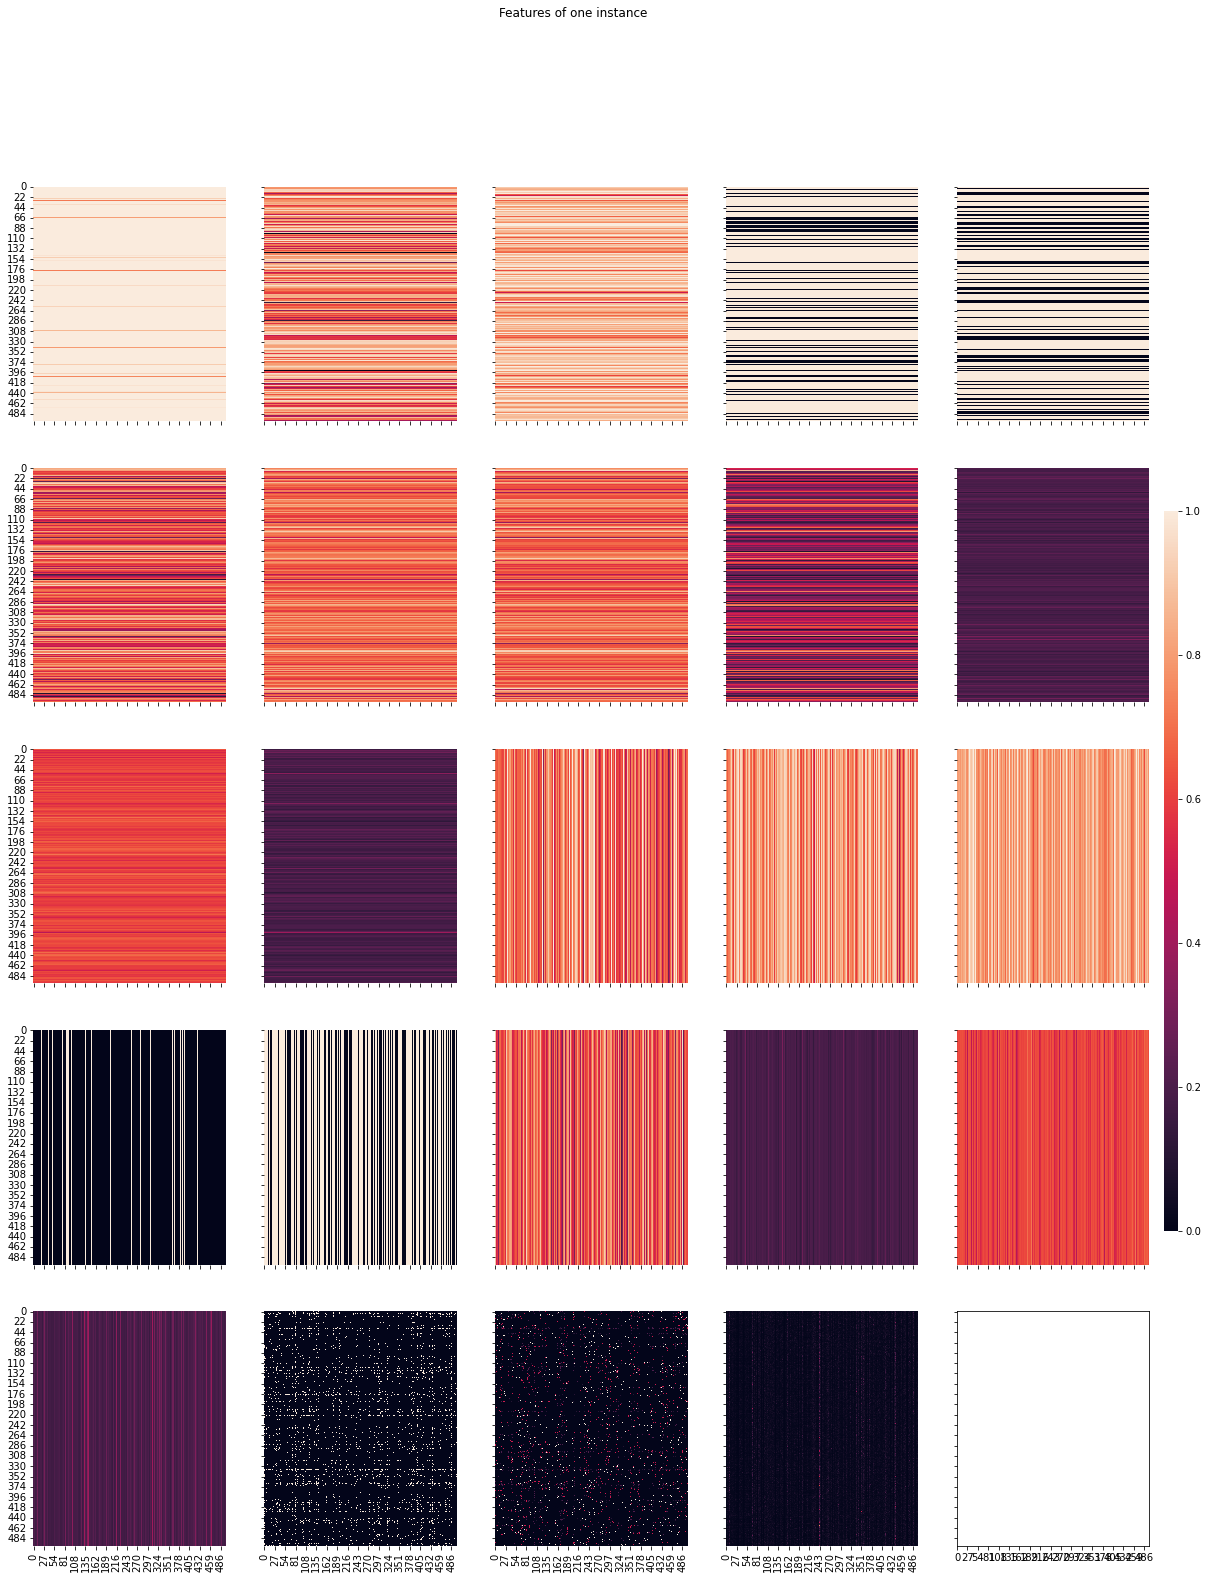

In [133]:
fig, axn = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,25))
cbar_ax = fig.add_axes([.91, .3, .01, .4])
plt.suptitle("Features of one instance")

for i, ax in enumerate(axn.flat):
    if i < N_FEATURES :
        sns.heatmap(X_train[1,:,:,i], ax=ax,
                    cbar=i == 0,
                    vmin=0, vmax=1,
                    cbar_ax=None if i else cbar_ax)
    if i == N_FEATURES : 
        sns.heatmap(Y_train[1], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)
    if i == N_FEATURES + 1 :
        sns.heatmap(Yemb_train[1], ax=ax,
                    cbar=i == 0,
                    vmin=0, vmax=1,
                    cbar_ax=None if i else cbar_ax)

#### Plot of hidden layers weights

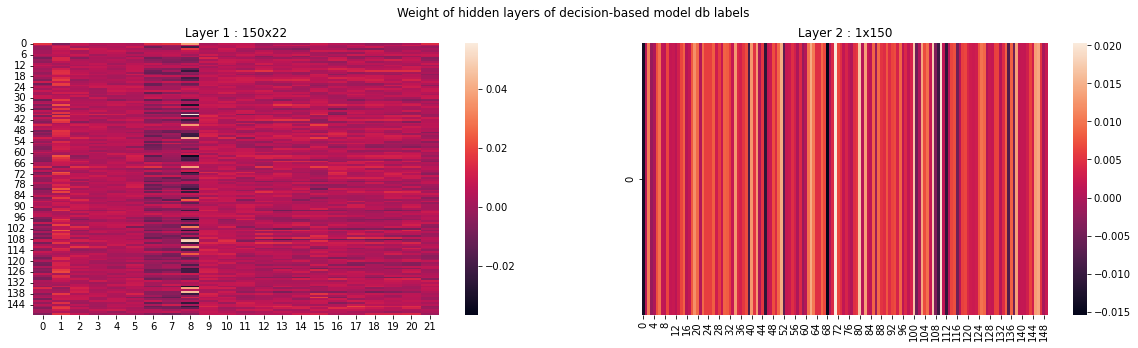

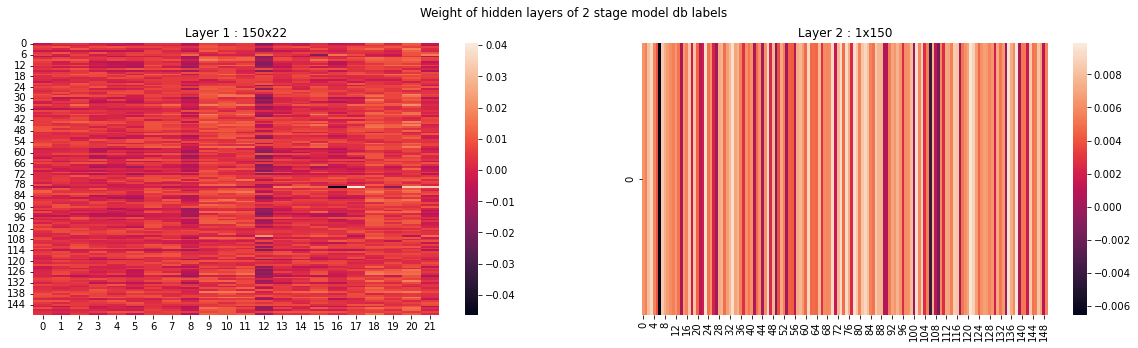

In [199]:
def print_hidden_layers(net, title) : 
    fig,ax = plt.subplots(1 , num_layers, figsize = (20,5))
    plt.suptitle(title)

    for i,ax in enumerate(ax.flat) :
        weights = net[3*i].weight.detach().cpu().numpy()
        sns.heatmap(weights, ax=ax)
        ax.set_title(f'Layer {i + 1} : {weights.shape[0]}x{weights.shape[1]}')
        
print_hidden_layers(net_df, 'Weight of hidden layers of decision-based model db labels')
print_hidden_layers(net_2s, 'Weight of hidden layers of 2 stage model db labels')

#### Comparison between output of model and labels

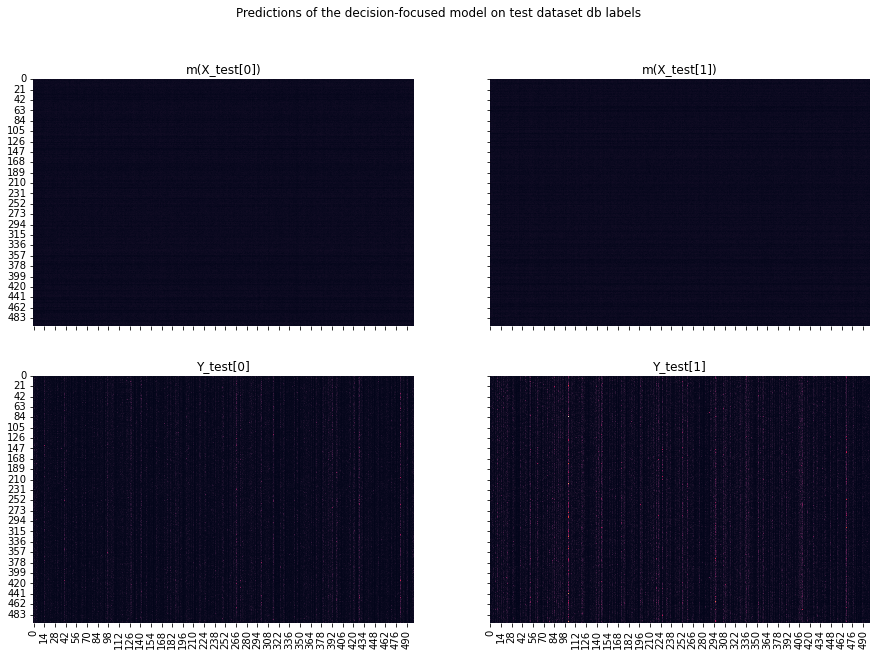

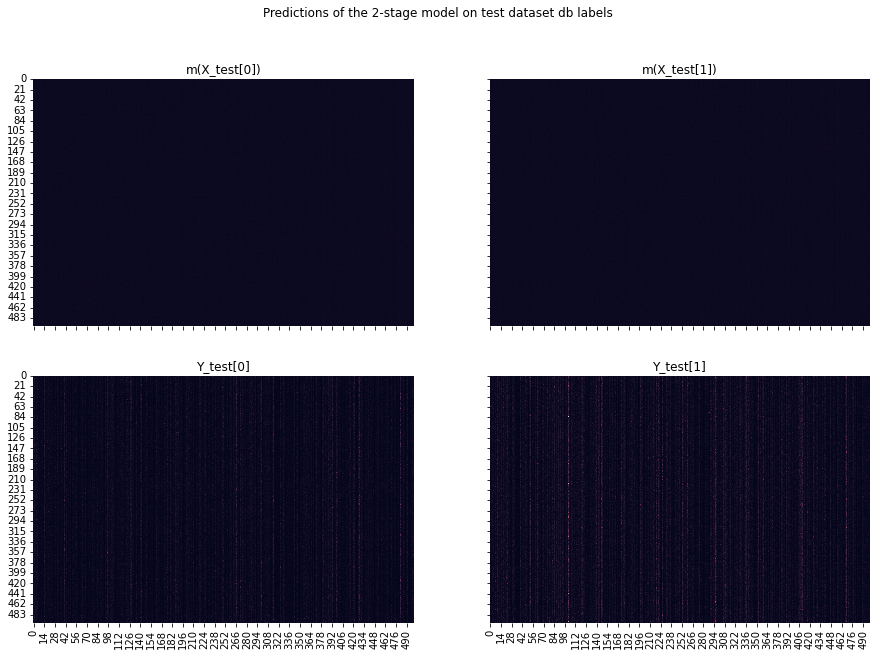

In [201]:
def print_output_test(net, title) :
    fig,ax = plt.subplots(2, 2, figsize = (15,10),sharex=True, sharey=True)
    # cbar_ax = fig.add_axes([.91, .3, .01, .4])
    #netcpu = copy.deepcopy(net).to('cpu')
    plt.suptitle(title)
    for i,ax in enumerate(ax.flat) :
        if i < 2 : 
            sns.heatmap(net(X_test[i].to(device)).view_as(Y_test[0]).detach().cpu(), 
                        ax=ax, 
                        vmax = 1, 
                        vmin = 0, 
                        cbar_ax = None if i else cbar_ax,
                        cbar=(i==0)
            )
            ax.set_title(f'm(X_test[{i}])')
        else : 
            sns.heatmap(Y_test[i-2], 
                        ax=ax, 
                        vmax = 1, 
                        vmin = 0, 
                        cbar_ax = None if i else cbar_ax,
                        cbar=(i==0)
            )
            ax.set_title(f'Y_test[{i-2}]')

print_output_test(net_df, "Predictions of the decision-focused model on test dataset db labels")
print_output_test(net_2s, "Predictions of the 2-stage model on test dataset db labels")

#### Comparison of influence between models and random and greedy

In [202]:
def compare_grd(net,X,Y) : 
    pred = eval_grd(net, X,Y)
    X, Y = X.to(device), Y.to(device)
    th = np.mean([greedy(k, Y[i,:,:].to(device),w)[0].item() for i in range(X.shape[0])])
    del(X)
    del(Y)
    print(f"The model predicts maximum influence {pred}")
    print(f"The theoretical maximum influence is {th}")
    
print("Decision_based on train dataset : ")
compare_grd(net_df, X_train, Y_train)
print("\n Decision_based on test dataset : ")
compare_grd(net_df, X_test, Y_test)
print("2-stage on train dataset : ")
compare_grd(net_2s, X_train, Y_train)
print("\n 2-stage on test dataset : ")
compare_grd(net_2s, X_test, Y_test)

Decision_based on train dataset : 
The model predicts maximum influence 226.33102989196777
The theoretical maximum influence is 229.1355686187744

 Decision_based on test dataset : 
The model predicts maximum influence 217.9415512084961
The theoretical maximum influence is 220.93914794921875
2-stage on train dataset : 
The model predicts maximum influence 221.1816806793213
The theoretical maximum influence is 229.1355686187744

 2-stage on test dataset : 
The model predicts maximum influence 211.08301544189453
The theoretical maximum influence is 220.93914794921875


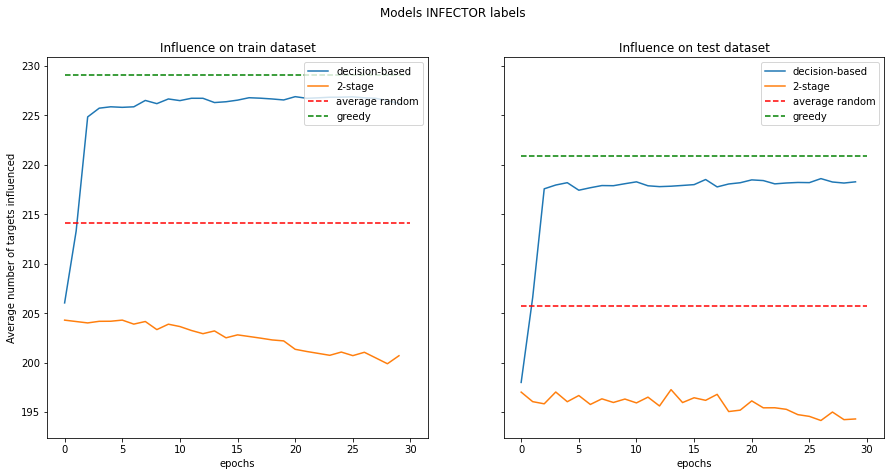

In [204]:
greedy_train = np.mean([greedy(k, Y_train[i,:,:].to(device),w)[0].item() for i in range(Y_train.shape[0])])
greedy_test = np.mean([greedy(k, Y_test[i,:,:].to(device),w)[0].item() for i in range(Y_test.shape[0])])

def compare_score_model(train_scores_df, test_scores_df, train_scores_2s, test_scores_2s, title="", rd_score_xtrain=0, rd_score_xtest=0):
    fig,ax = plt.subplots(1,2, figsize = (15,7), sharey=True)
    n = min(len(test_scores_2s),len(test_scores_df))

    ax[0].plot(train_scores_df[:n], label='decision-based')# ax = ax[0])
    ax[0].plot(train_scores_2s[:n], label='2-stage')# ax = ax[0])
    ax[0].hlines(y=rd_score_xtrain, xmin=0, xmax=n, linestyle='--', color='red', label='average random')
    ax[0].hlines(y=greedy_train, xmin=0, xmax=n, linestyle='--', color='green', label='greedy')
    ax[0].legend(loc='upper right')
    ax[0].set_title("Influence on train dataset")
    ax[0].set_ylabel('Average number of targets influenced')
    ax[0].set_xlabel('epochs')

    ax[1].plot(test_scores_df[:n],label='decision-based')
    ax[1].plot(test_scores_2s[:n], label='2-stage')
    ax[1].hlines(y=rd_score_xtest, xmin=0, xmax=n, linestyle='--', color='red', label='average random')
    ax[1].hlines(y=greedy_test, xmin=0, xmax=n, linestyle='--', color='green', label='greedy')
    ax[1].legend(loc='upper right')
    ax[1].set_title("Influence on test dataset")
    ax[1].set_xlabel('epochs')

    fig.suptitle(title)
    plt.show()

compare_score_model(train_scores_df,test_scores_df, train_scores_2s, test_scores_2s, "Models INFECTOR labels", rd_score_xtrain, rd_score_xtest, )


end